# Stock Portfolio Analysis using Time Series Forecasting

## Getting the necessary packages

In [1]:
#installing the packages necessary (run this cell if all the packages are not installed)
!pip install pandas yfinance matplotlib pmdarima numpy statsmodels

In [2]:
#importing the packages
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## Fetching the data

In [3]:
#in this project, we are taking a portfolio that consists of 10 CPG manufacturing companies
#KO - Coca-Cola
#PEP - PepsiCo
#CL - Colgate-Palmolive
#KHC - The Kraft Heinz Company
#MDLZ - Mondelez International
#GIS - General Mills
#EL - Estée Lauder
#KMB - Kimberly-Clark
#STZ - Constellation Brands
#CLX - The Clorox Company

stock_list = ["PEP", "KO", "CL", "KHC", "MDLZ", "GIS", "EL", "KMB", "STZ", "CLX"]


In [4]:
#fetching the stocks data from yahoo finance for 5 years

start_date = "2018-01-01"
end_date = "2023-01-01"

stock_data = yf.download(stock_list, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  10 of 10 completed


In [5]:
stock_data.head()

,CL,CLX,EL,GIS,KHC,KMB,KO,MDLZ,PEP,STZ
Date,,,,,,,,,,
2018-01-02,63.933945,119.984161,118.089485,46.690475,56.405239,94.477898,37.069431,36.624218,96.932877,205.343597
2018-01-03,63.687168,118.693199,119.968323,46.445305,56.397938,92.898895,36.988022,36.771015,96.678352,206.195557
2018-01-04,64.095619,120.563461,120.532875,46.983074,57.057056,93.970078,37.508991,36.857376,97.154533,204.645691
2018-01-05,64.172188,120.596504,120.310783,47.386395,57.005756,93.763763,37.500854,37.332340,97.433678,199.289185
2018-01-08,64.265800,121.184090,121.217781,47.544559,57.474464,94.763542,37.443871,37.142349,96.875397,196.533783


In [6]:
stock_data.shape

(1259, 10)

## Cleaning and preprocessing

In [7]:
#checking for null values
for stock, data in stock_data.items():
    missing_values = data.isnull().sum()
    if missing_values > 0:
        print(f"Missing values in {stock}: {missing_values}")

In [8]:
#there are no missing values in the data
#in case there will be any missing values in future, 
#this cod will replace the missing/null values with previous day value

for stock, data in stock_data.items():
    stock_data[stock].fillna(method='ffill', inplace=True)

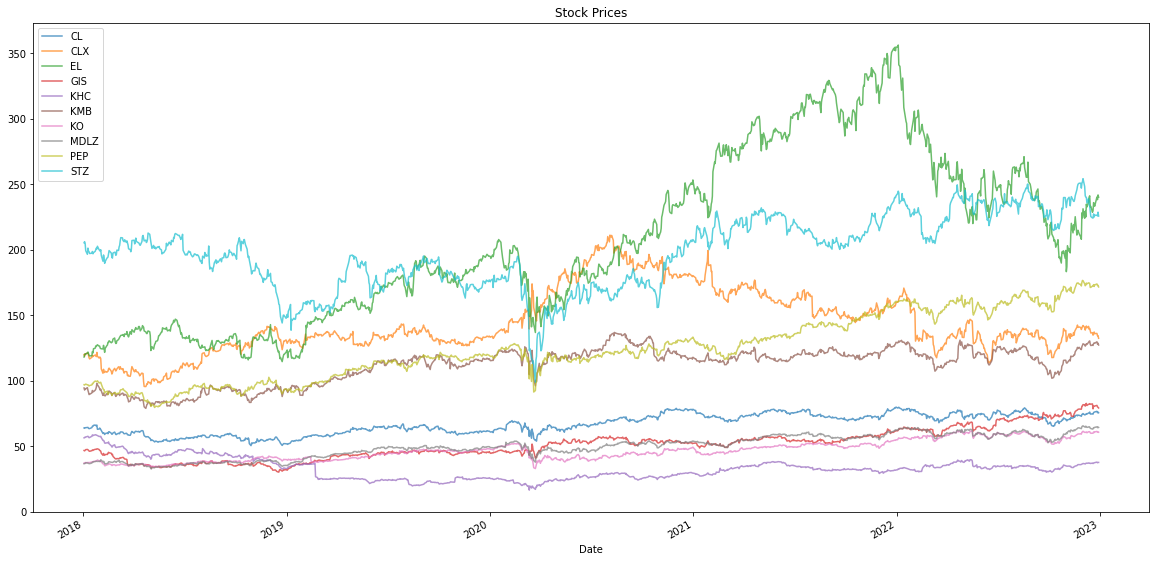

In [9]:
#visualizing each stock in a line graph
plt.figure(figsize=(20, 10))

for stock, data in stock_data.items():
    data.plot(label=stock, alpha=0.7)

plt.title('Stock Prices')
plt.legend()
plt.show()


#### Observation:  We can see from the above plot that there was a slight down decrease in closing price of all the stocks except for CLX - Clorax in the first quater of 2020

In [10]:
#handling the outliers iterating through each stock
for cpg in stock_list:
    temp_stock_data = stock_data[cpg]
    
    #we are clipping the extreme values so that the data is not skewed
    #the quantiles can be customized as per the requirement
    #now we are taking lower and upper threshold values as 0.01 and 0.99
    lower_threshold = temp_stock_data.quantile(0.05)
    upper_threshold = temp_stock_data.quantile(0.95)
    temp_stock_data_clipped = temp_stock_data.clip(lower=lower_threshold, upper=upper_threshold)
    stock_data[cpg] = temp_stock_data_clipped

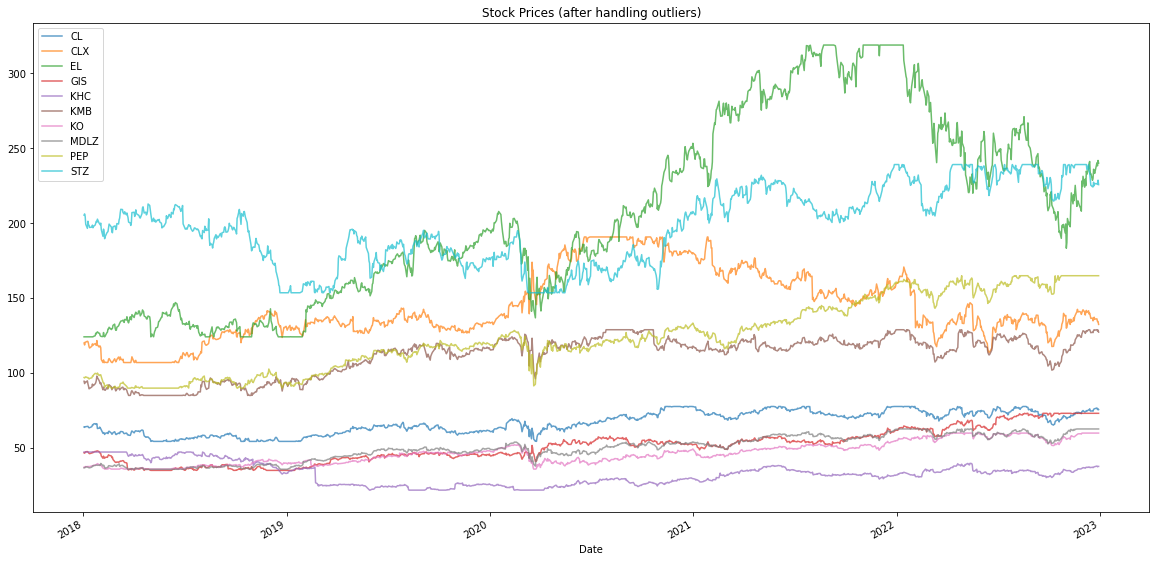

In [11]:
#visualizing each stock in a line graph after handling the outliers
plt.figure(figsize=(20, 10))

for stock, data in stock_data.items():
    data.plot(label=stock, alpha=0.7)

plt.title('Stock Prices (after handling outliers)')
plt.legend()
plt.show()

## Daily Returns

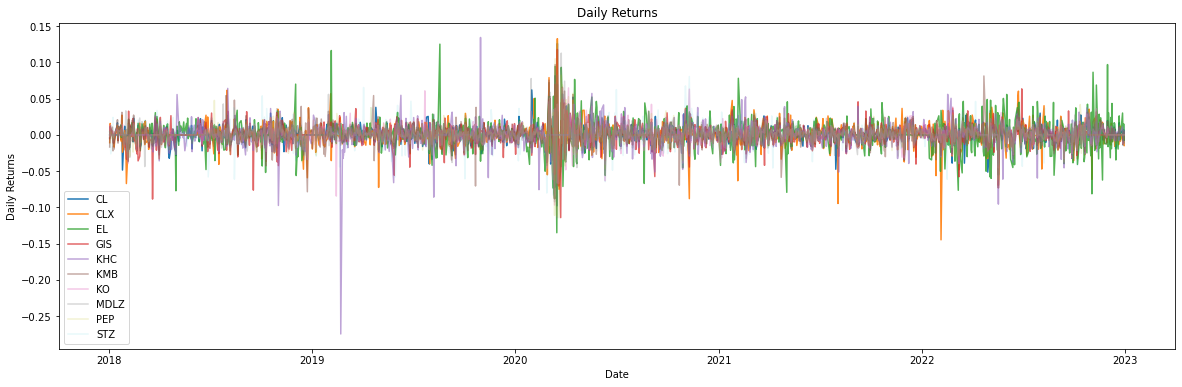

In [12]:
#we can calculate daily returns with pct_change()
stock_returns = stock_data.pct_change().dropna()

#visualizing pct change
plt.figure(figsize=(20, 6))
for i, stock in enumerate(stock_returns.columns):
    alpha_value = 1.0 - (i / len(stock_returns.columns))  # Unique transparency for each stock
    plt.plot(stock_returns.index, stock_returns[stock], label=stock, alpha=alpha_value)

plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.show()

## Sharpe Ratio

{'CL': 0.2646739207000775, 'CLX': 0.20573043674696784, 'EL': 0.5737091498029782, 'GIS': 0.5106230560948027, 'KHC': -0.022889813579830078, 'KMB': 0.3797093355473423, 'KO': 0.5765789208361894, 'MDLZ': 0.6112788800214619, 'PEP': 0.6025177839417192, 'STZ': 0.19800773919986409}


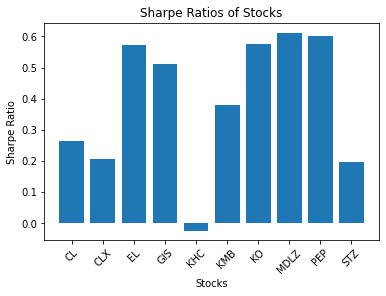

In [13]:
# Calculate Sharpe ratio for each stock
sharpe_ratio = {}
for stock in stock_returns.columns:
    daily_ret_mean = stock_returns[stock].mean()
    daily_ret_stddev = stock_returns[stock].std()
    temp_sharpe = np.sqrt(252) * (daily_ret_mean / daily_ret_stddev)
    sharpe_ratio[stock] = temp_sharpe

print(sharpe_ratio)

# Visualize Sharpe ratios
plt.bar(sharpe_ratio.keys(), sharpe_ratio.values())
plt.title('Sharpe Ratios of Stocks')
plt.xlabel('Stocks')
plt.ylabel('Sharpe Ratio')
plt.xticks(rotation=45)
plt.show()

### Observation: Only the KHC has negative sharpe ratio and it might not offer better returns. EL, KO, MDLZ and PEP offer better risk adjustment when compared to other stocks.

## Stationarity Check

In [14]:
# Check for stationarity using ADF test
def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

for stock, data in stock_data.items():
    print(f"Stationarity check for {stock}:")
    check_stationarity(data)


Stationarity check for CL:
ADF Statistic: -1.5826421660722425
p-value: 0.4923067937996977
Critical Values:
   1%: -3.4356006420838963
   5%: -2.8638586845641063
   10%: -2.5680044958343604
Stationarity check for CLX:
ADF Statistic: -1.5510384584688768
p-value: 0.508129431376557
Critical Values:
   1%: -3.4356133204636095
   5%: -2.8638642784217305
   10%: -2.5680074748794373
Stationarity check for EL:
ADF Statistic: -1.4307873460398377
p-value: 0.5674305549886687
Critical Values:
   1%: -3.4355629707955395
   5%: -2.863842063387667
   10%: -2.567995644141416
Stationarity check for GIS:
ADF Statistic: 0.05954482859842111
p-value: 0.9631879938397415
Critical Values:
   1%: -3.4355754676859886
   5%: -2.8638475772391665
   10%: -2.5679985805677017
Stationarity check for KHC:
ADF Statistic: -2.022923967922841
p-value: 0.2766130621020326
Critical Values:
   1%: -3.4355588184378574
   5%: -2.8638402312881497
   10%: -2.5679946684494275
Stationarity check for KMB:
ADF Statistic: -1.9140648549

Here are the observations and insights from the ADF test results:

1. **Interpretation of ADF Statistic and p-values**:
   - If the ADF statistic is less than the critical values and the corresponding p-value is lower than a specific threshold (e.g., 0.05), you can reject the null hypothesis, indicating the time series is likely stationary.
   - A higher p-value suggests a failure to reject the null hypothesis, indicating the time series might not be stationary.

2. **Individual Stock Observations**:
   - **KHC**: The ADF statistic is significantly low, and the p-value is below 0.05, suggesting the data is likely stationary.
   - **Others**: For most stocks, the ADF statistics are negative, which is a good sign for stationarity. However, the p-values are relatively high (above 0.05) for most stocks, indicating that the data might not be stationary.

3. **Actionable Insights**:
   - Stocks like KHC show stronger evidence of stationarity, which could potentially allow for easier modeling with time series techniques.
   - For stocks with higher p-values (e.g., KO, PEP, EL, etc.), further analysis or preprocessing steps might be needed to make the data stationary before applying time series models.

4. **Considerations**:
   - These results indicate that most stock data might not be stationary, possibly requiring transformations or differencing to achieve stationarity before modeling.
   - Other stationarity checks or transformations like differencing could be attempted to make the data suitable for time series analysis.

Overall, the ADF test results suggest that several stock time series might not be stationary based on the p-values obtained. For more accurate time series analysis and forecasting, achieving stationarity in the data might be necessary.

## Seasonal Decomposition

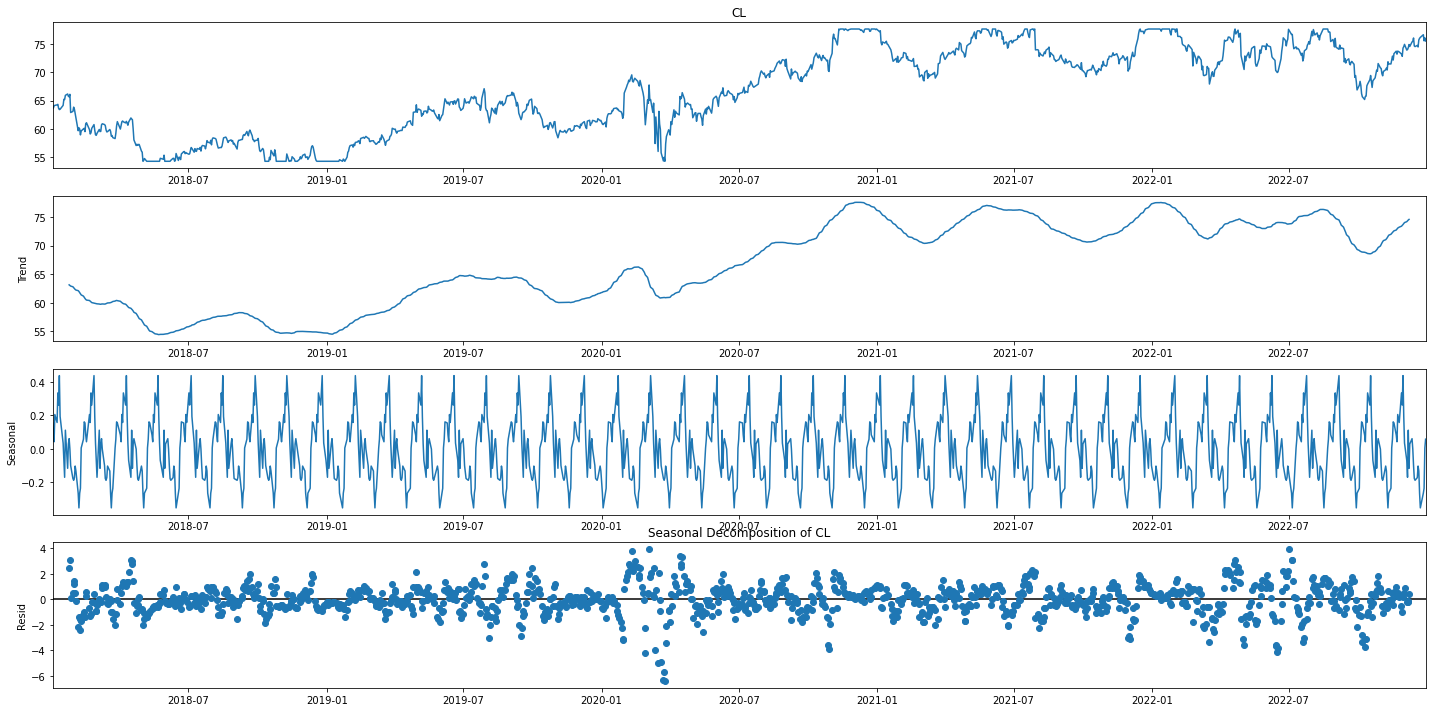

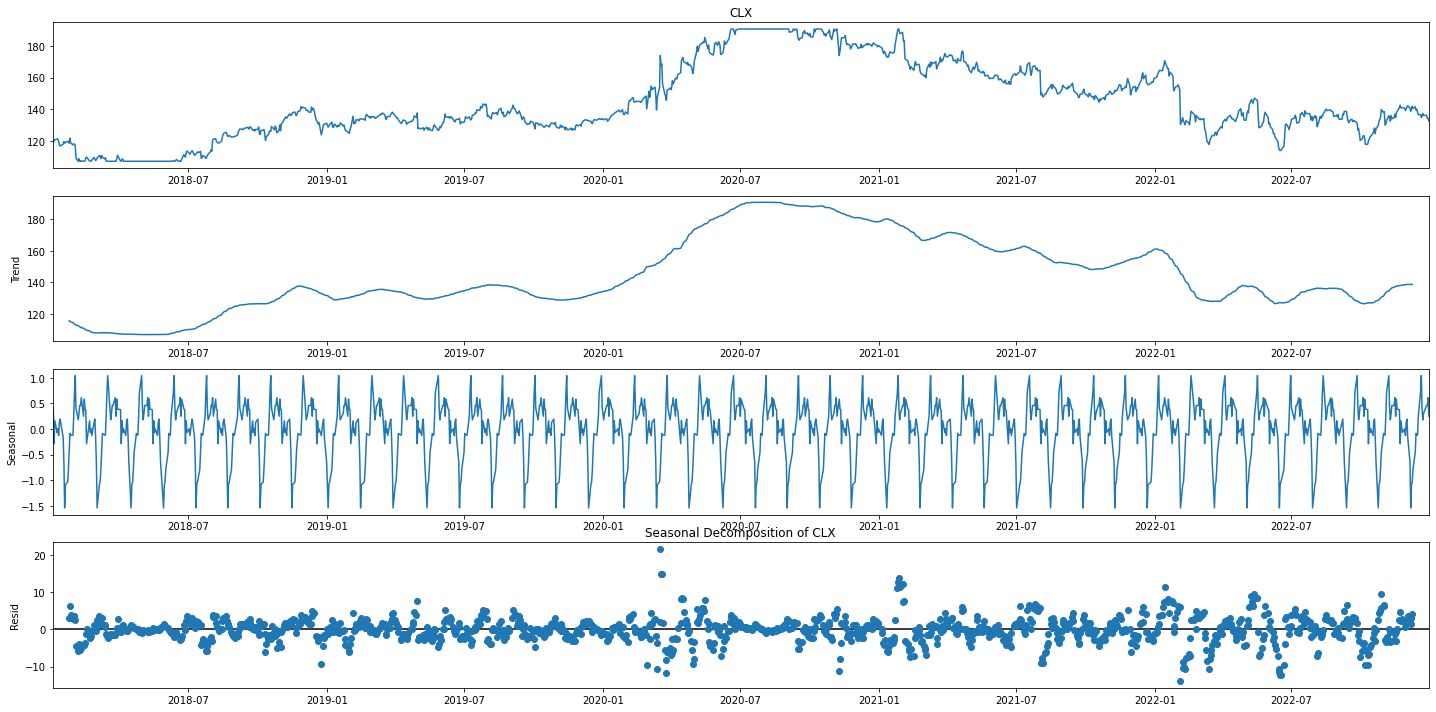

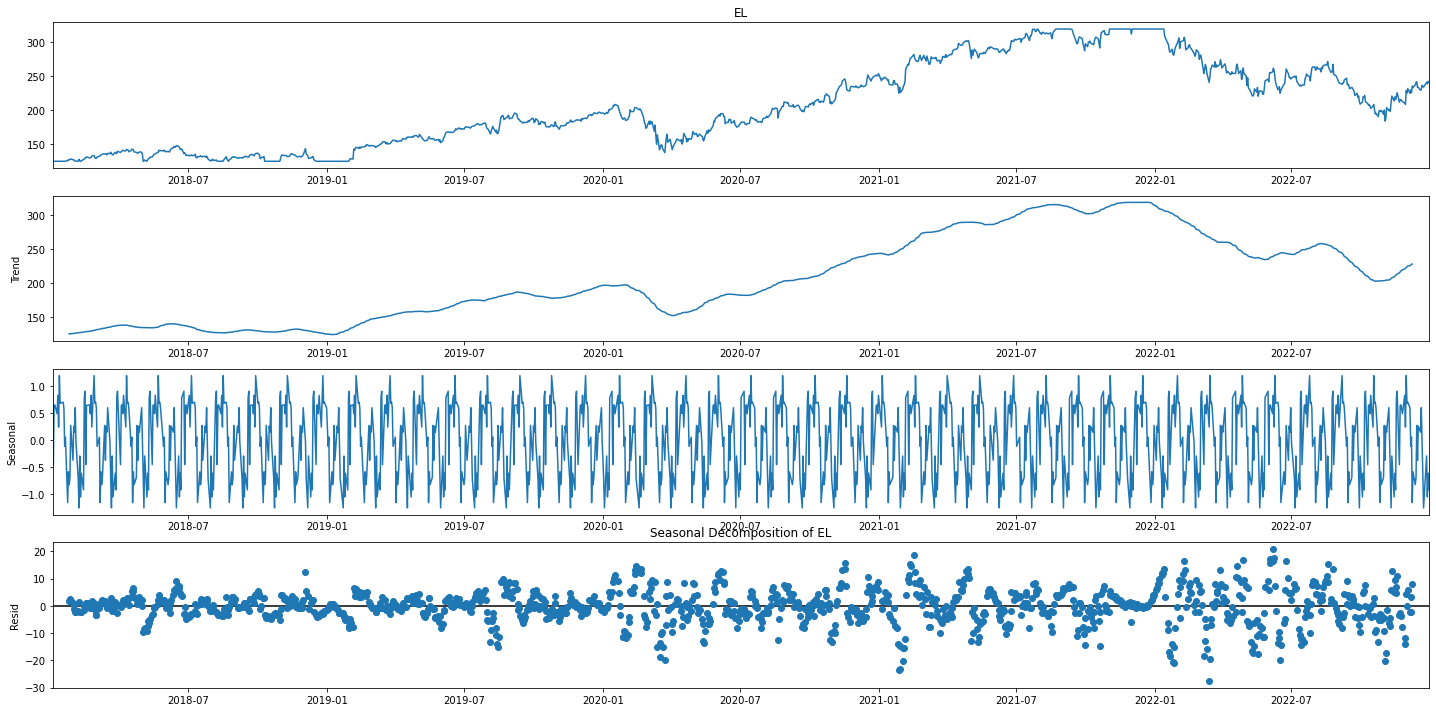

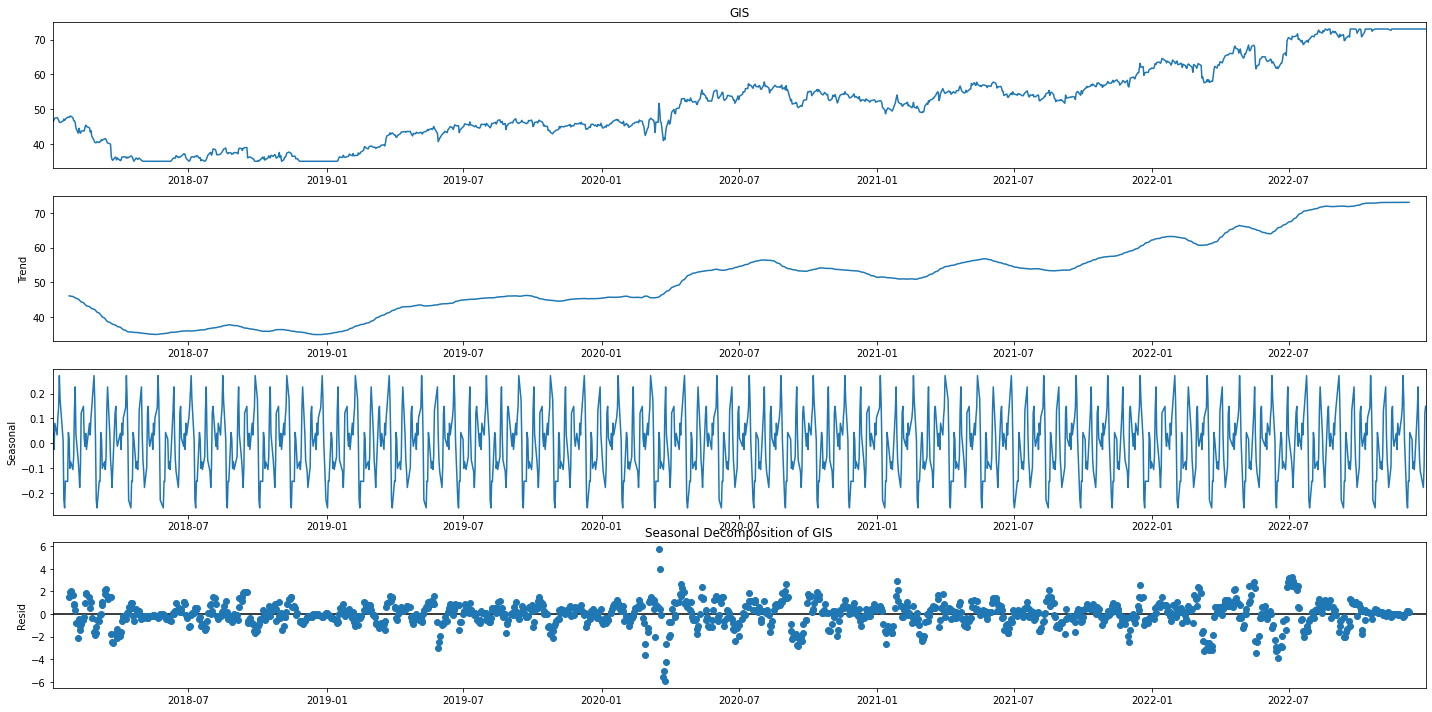

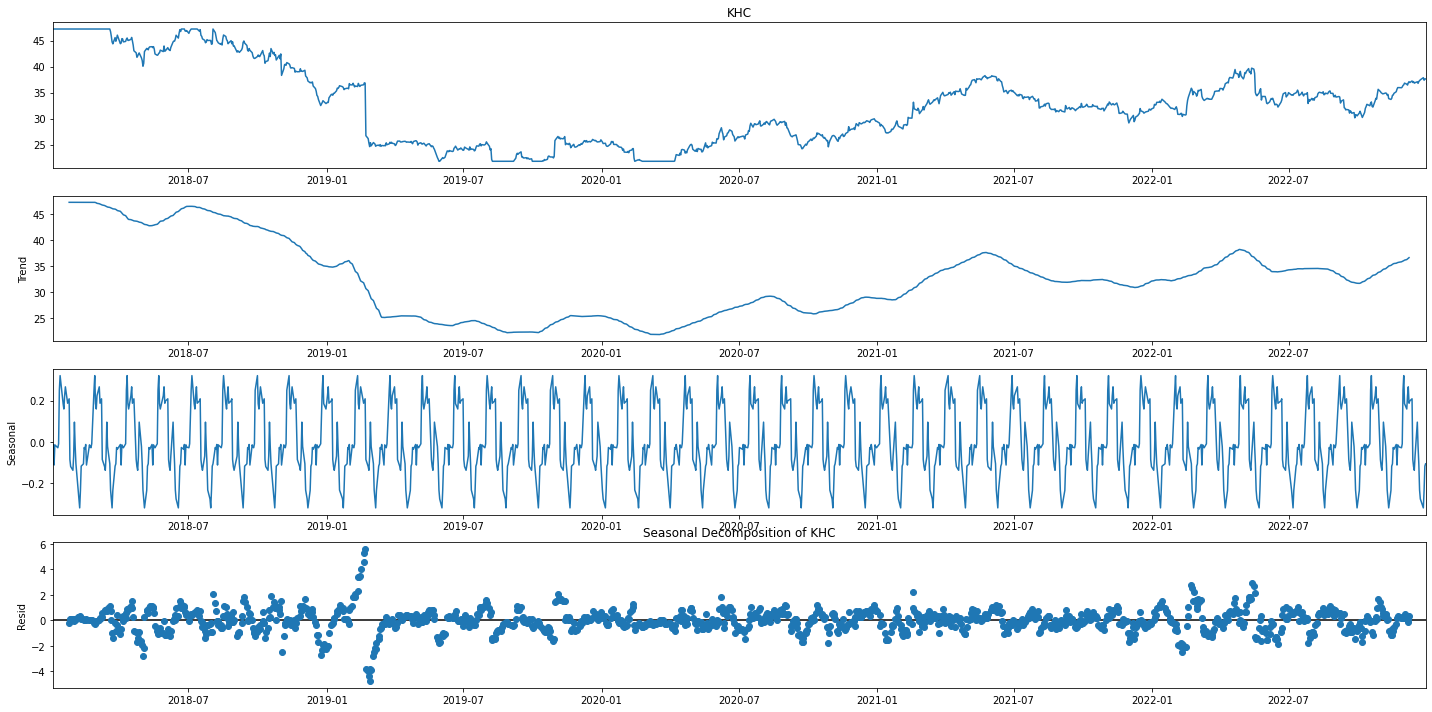

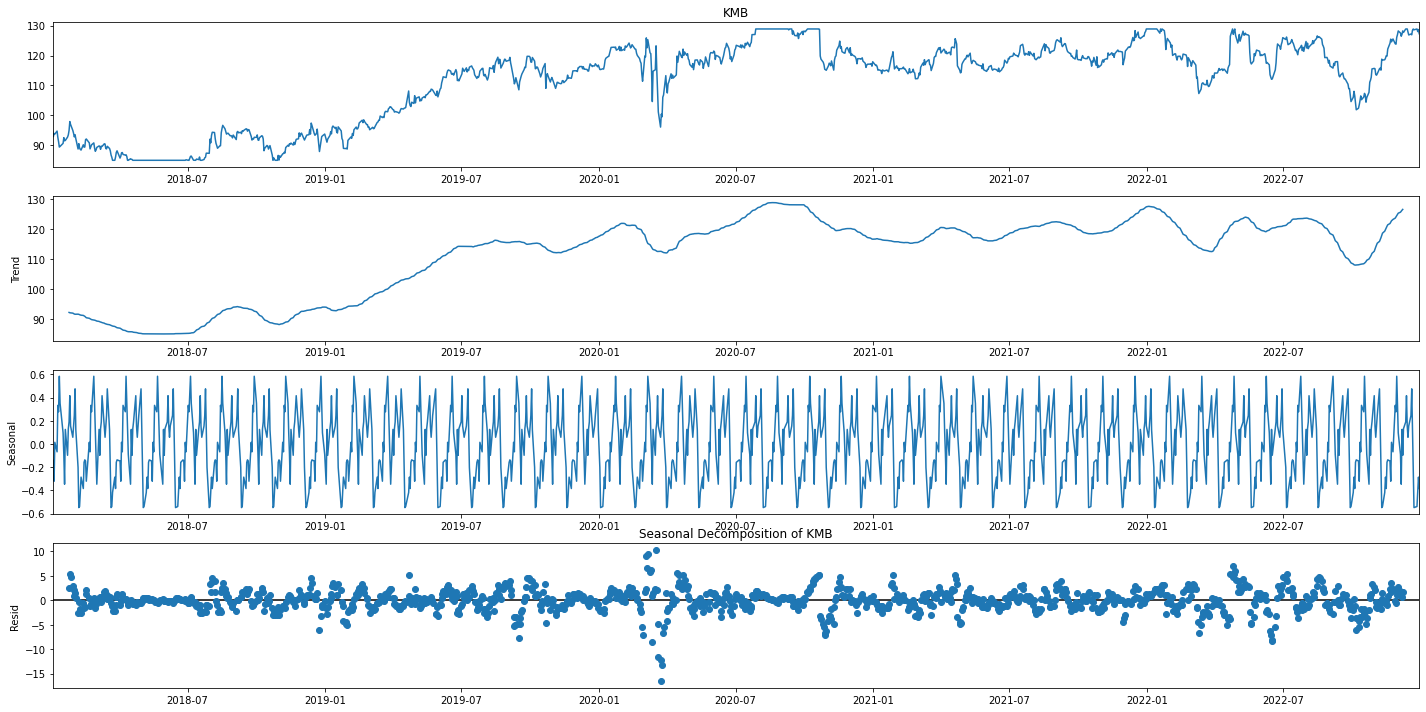

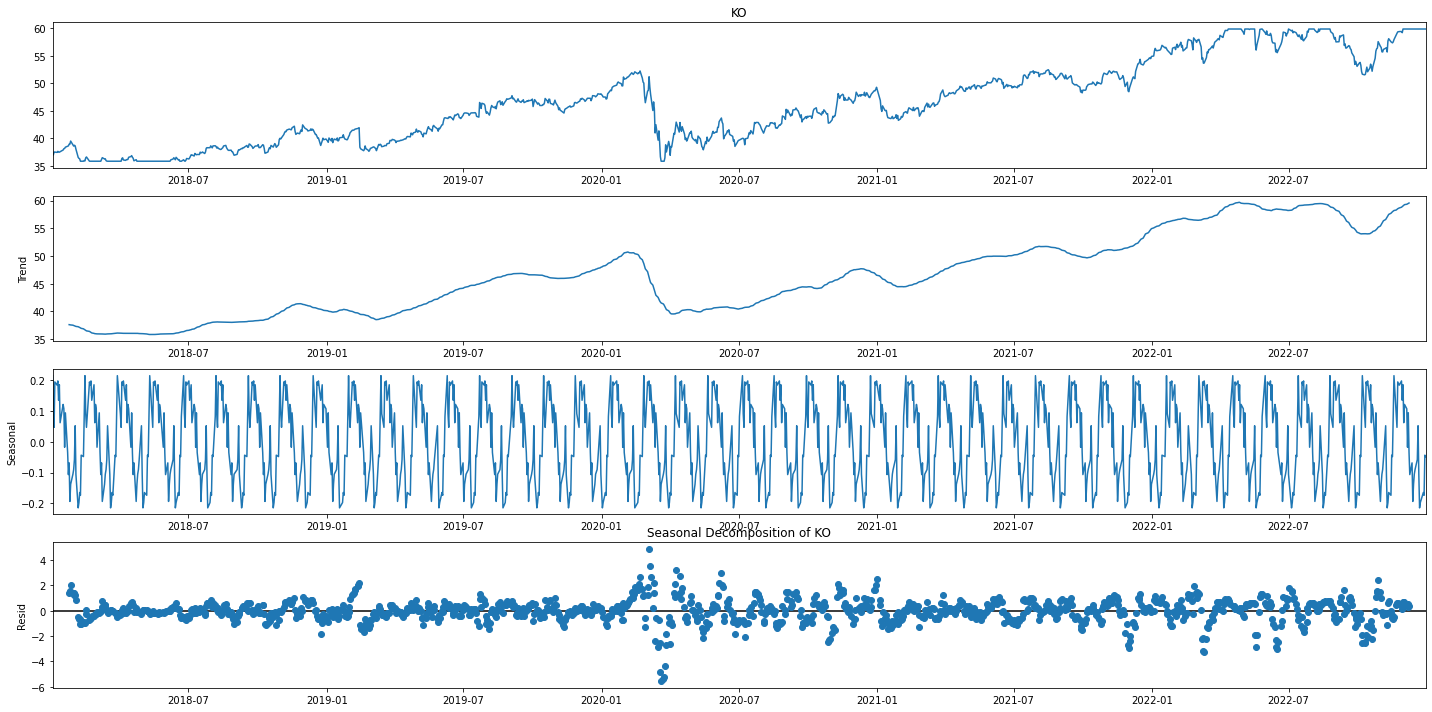

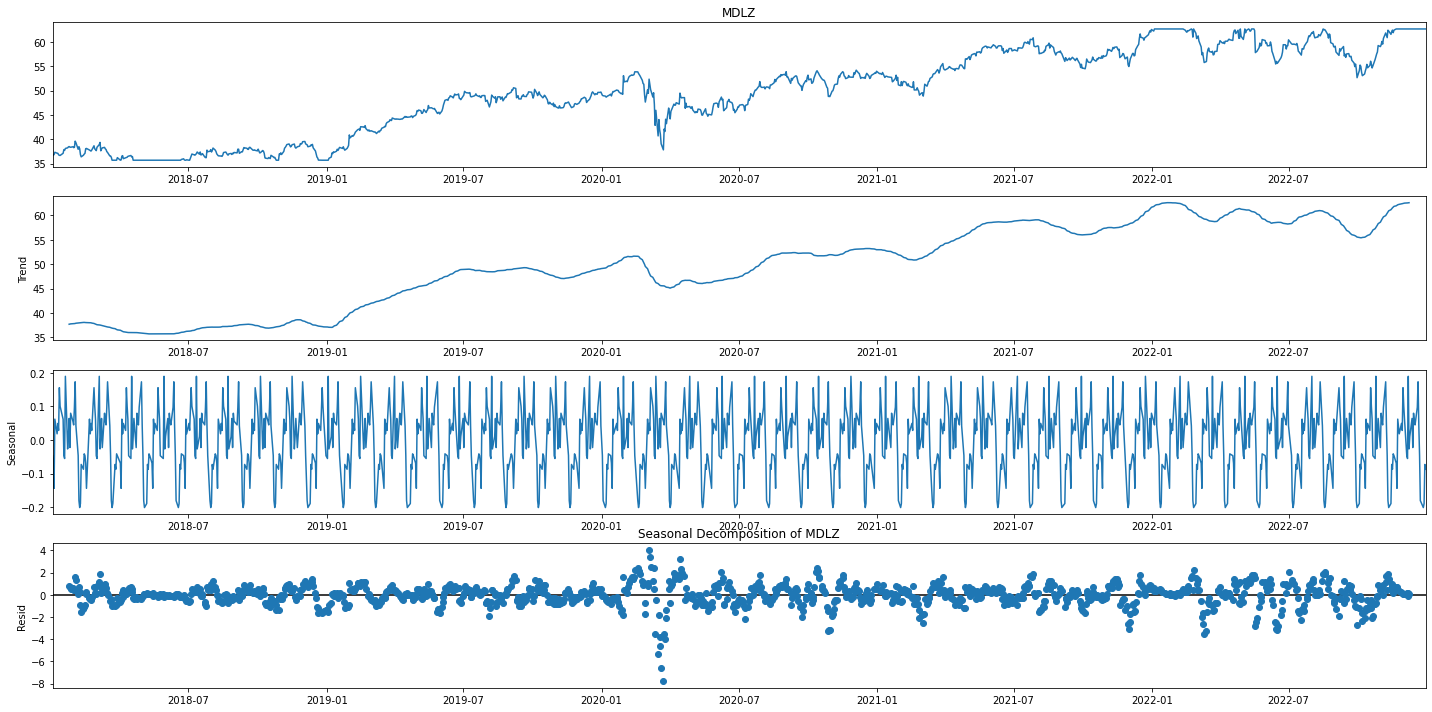

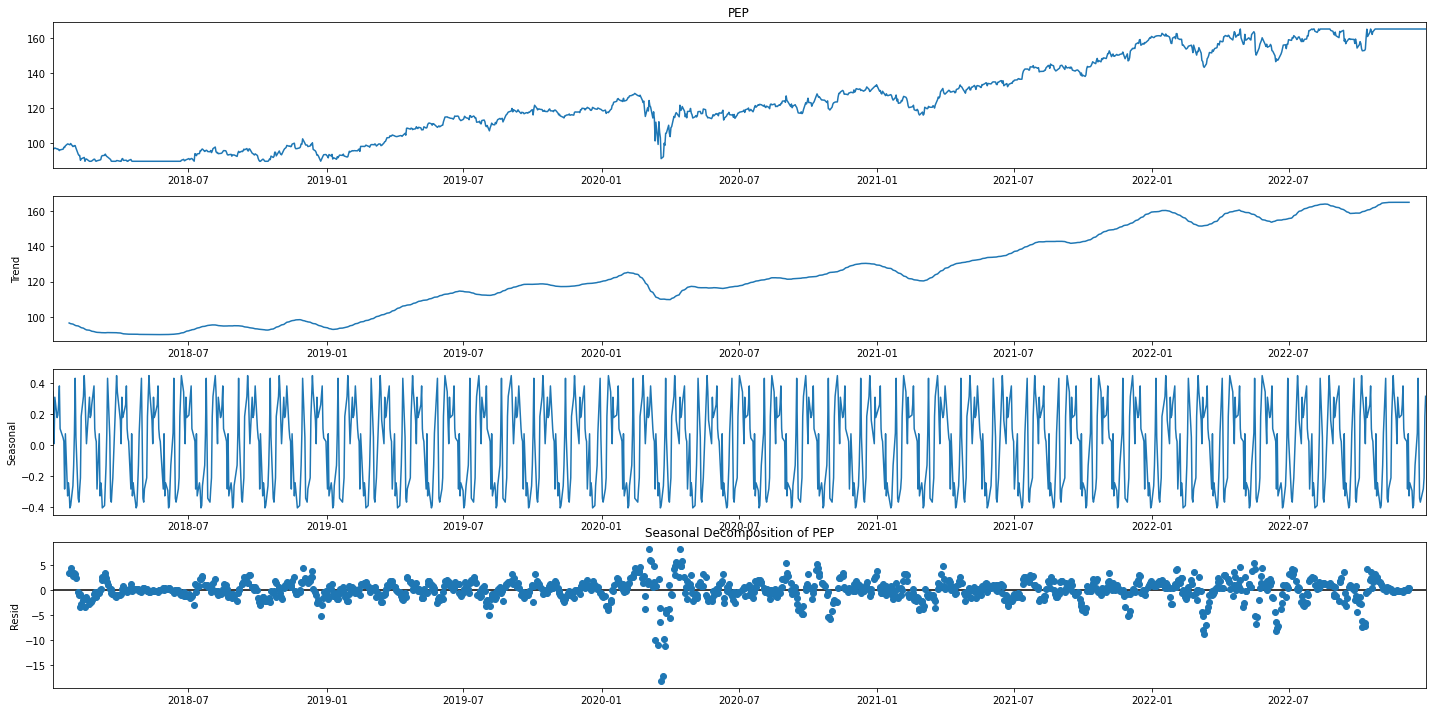

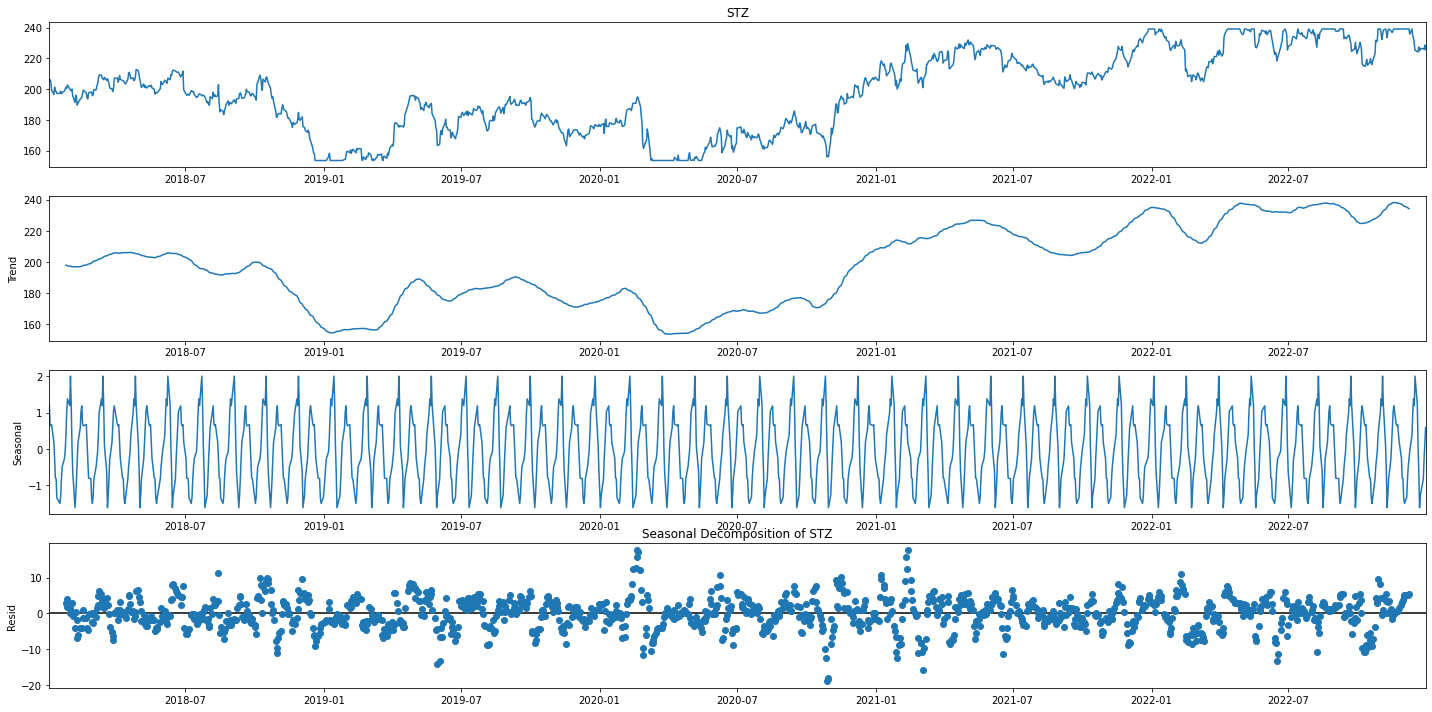

In [15]:
# Cheching Seasonal decomposition using the seasonal_decompose function
# here we assumed 30 days seasonality, hence period=30

plt.rcParams['figure.figsize'] = (20, 10)

for stock, data in stock_data.items():
    result = seasonal_decompose(data, model='additive', period=30)
    result.plot()
    
    plt.title(f'Seasonal Decomposition of {stock}')
    plt.show()


Seasonal decomposition graphs are used to break down a time series into its different components: trend, seasonality, and residual (or error) elements. These components provide insights into the underlying patterns present in the data and aid in understanding the overall behavior of the time series.

### Components of Seasonal Decomposition:

1. **Trend**:
   - The trend component represents the long-term movement or direction of the data. It highlights whether the series is generally increasing, decreasing, or stable over time.

2. **Seasonality**:
   - Seasonality captures regular, periodic fluctuations that occur at fixed intervals. For example, in monthly data, you might observe seasonality reflecting patterns that occur at the same months every year, like increased sales during the holiday season.

3. **Residual (or Error)**:
   - The residual component is the part of the series that cannot be explained by the trend or seasonality. It contains the random variations or noise in the data.

### Observations from Seasonal Decomposition Graphs:

1. **Identifying Trend and Seasonality**:
   - The decomposition allows you to visually identify the overall trend of the data and the seasonal patterns. Understanding the trend helps in forecasting long-term behavior, while recognizing seasonality aids in making predictions based on recurring patterns.

2. **Patterns Over Time**:
   - Observing consistent, repeating patterns in the seasonal component helps in understanding when peaks and troughs occur. For instance, sales spiking during holidays or a decline during certain months.

3. **Residual Analysis**:
   - Analyzing the residuals can indicate how well the trend and seasonal components explain the data. Ideally, residuals should show no specific pattern, meaning that the trend and seasonality have effectively been captured.

4. **Forecasting Insights**:
   - By separating trend, seasonality, and residuals, the decomposition helps in building models for forecasting. It provides a clearer view of how different components contribute to the overall time series behavior.

5. **Anomalies or Outliers**:
   - Sudden spikes or drops in the residual component might indicate anomalies or outliers in the data. These anomalies could be events that were not captured by the trend or seasonal patterns.

Overall, the seasonal decomposition graph provides a comprehensive understanding of the various components shaping the time series data. It aids in better modeling, trend analysis, and forecasting, enabling analysts to make more informed decisions based on the observed patterns and anomalies.

## ACF and PACF plots

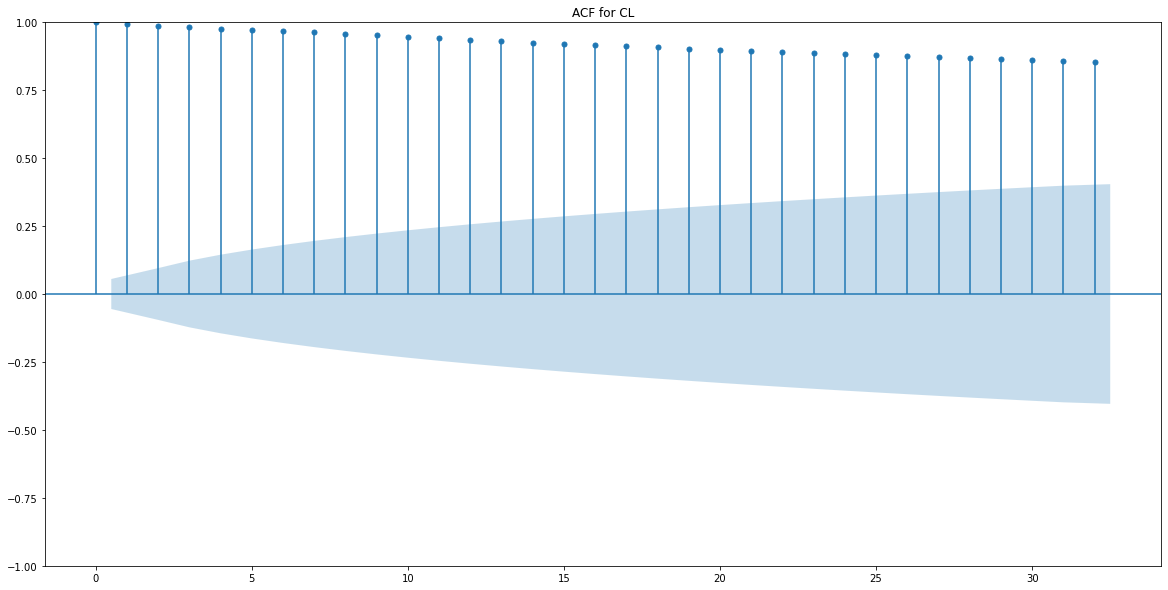

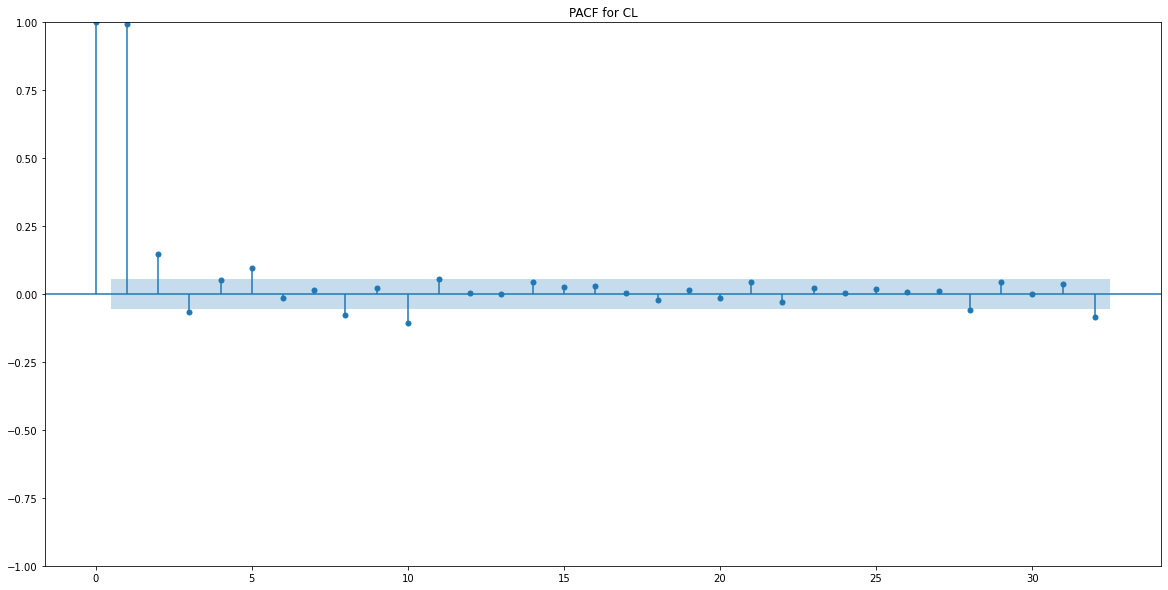

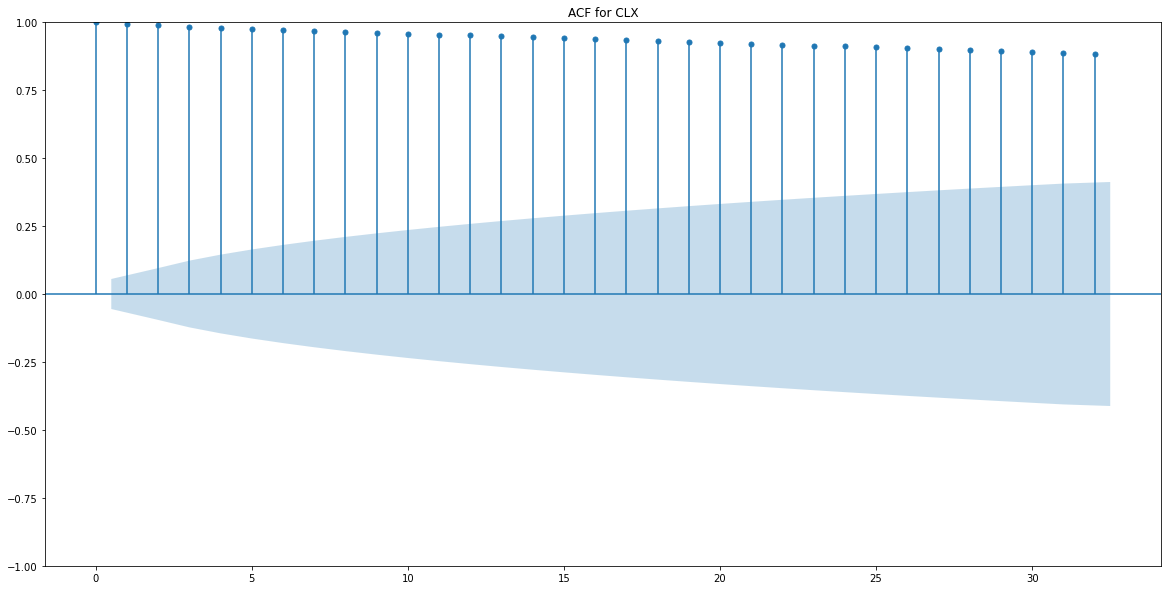

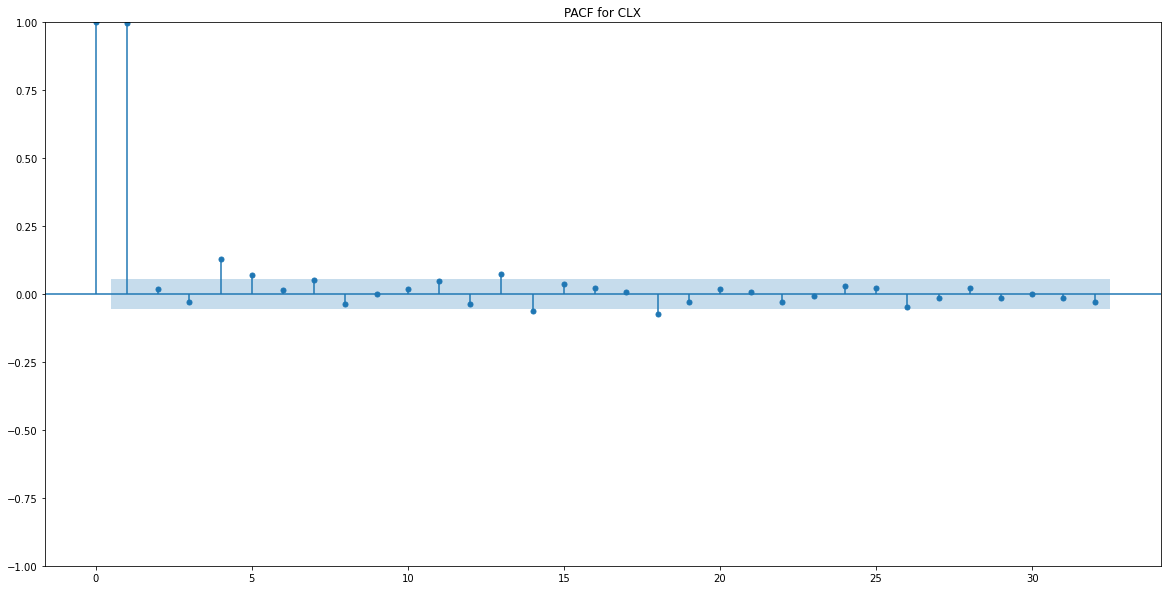

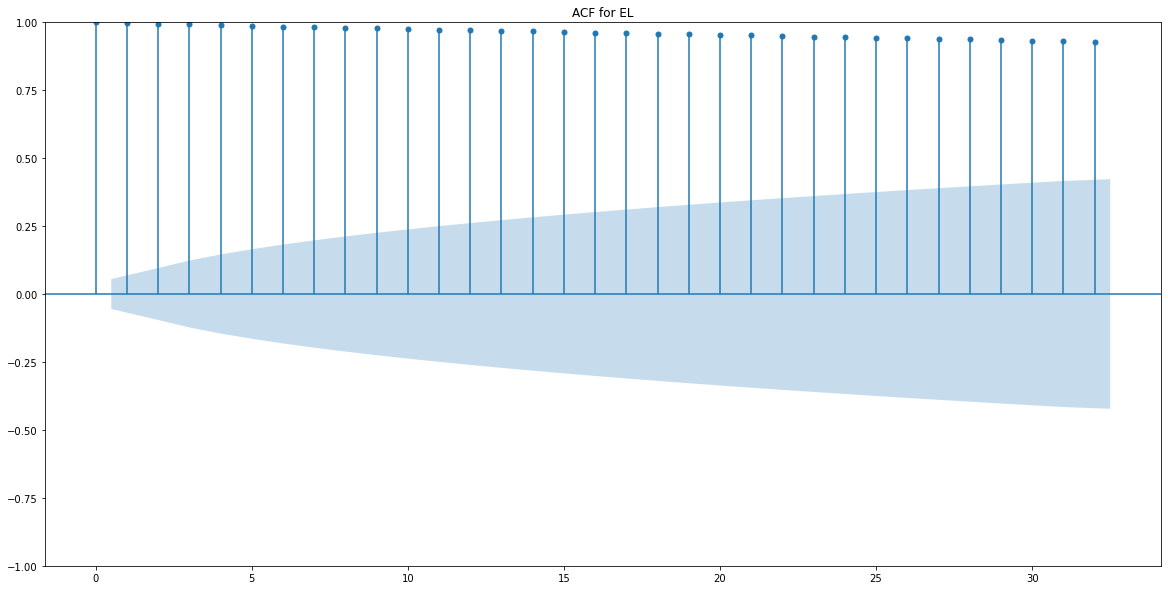

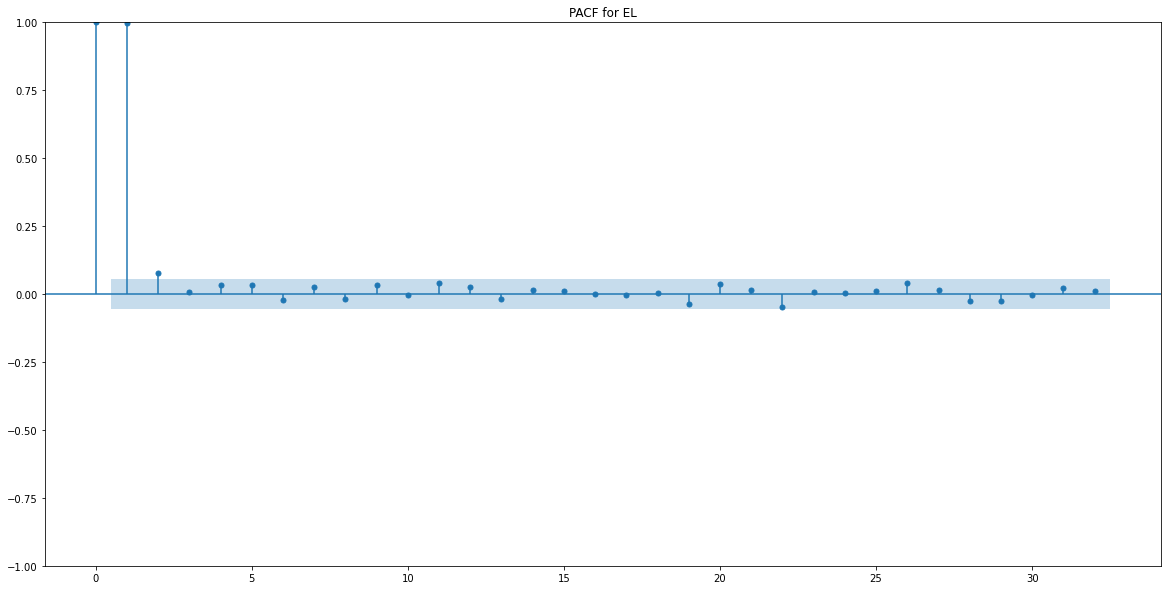

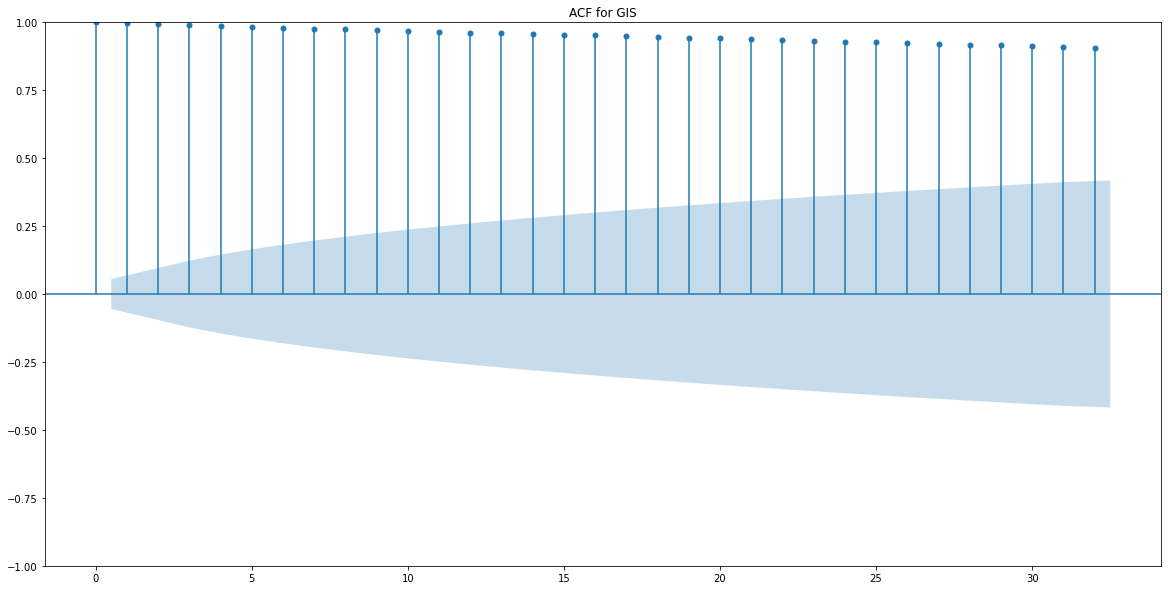

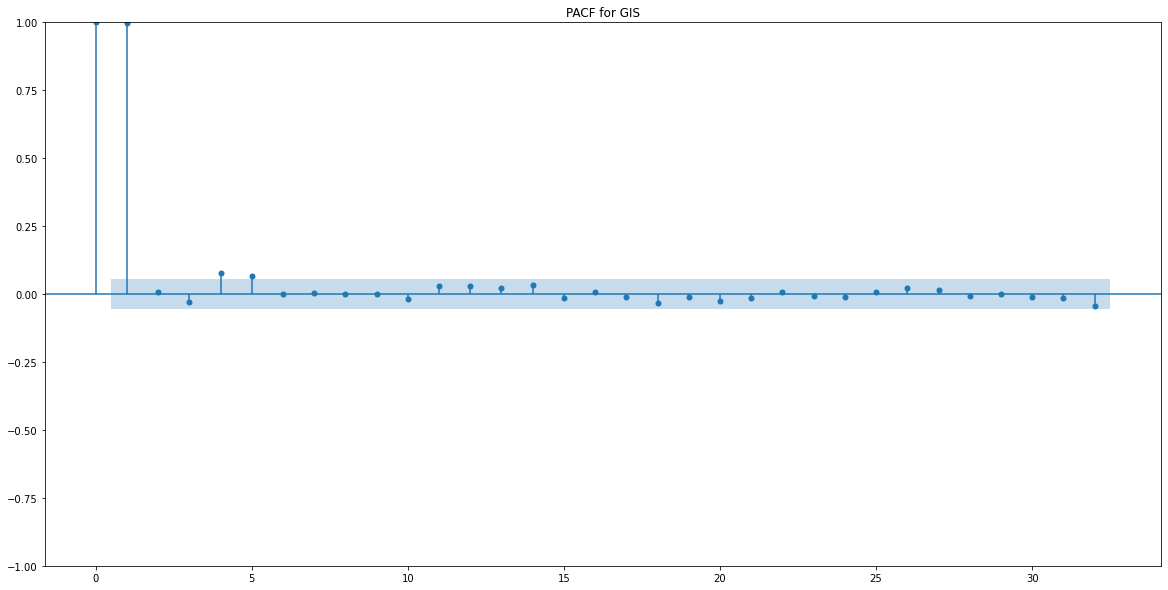

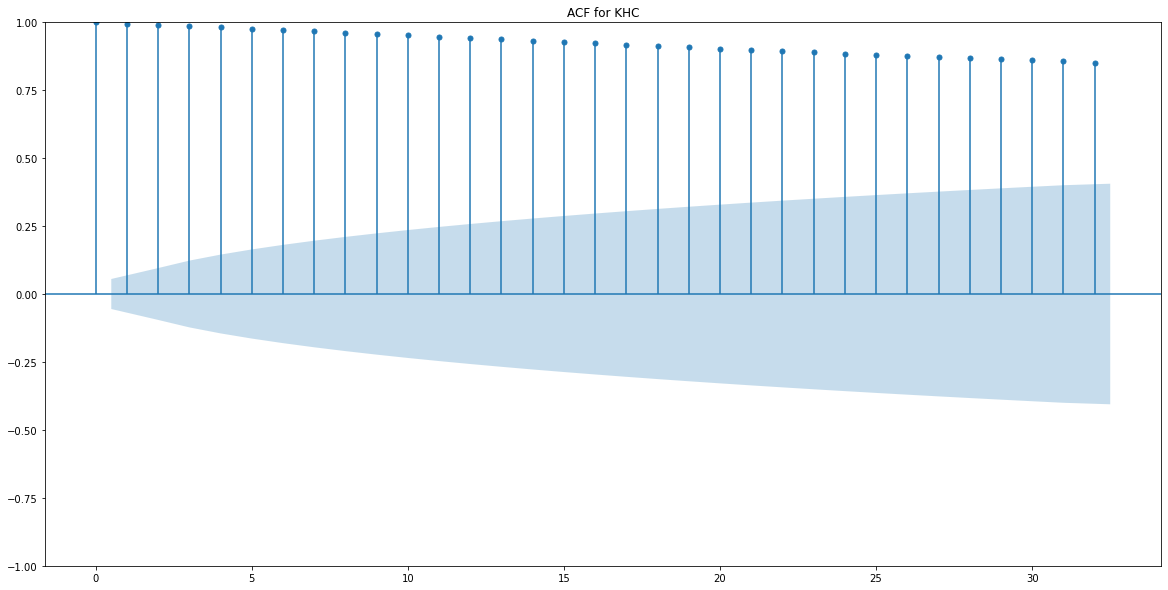

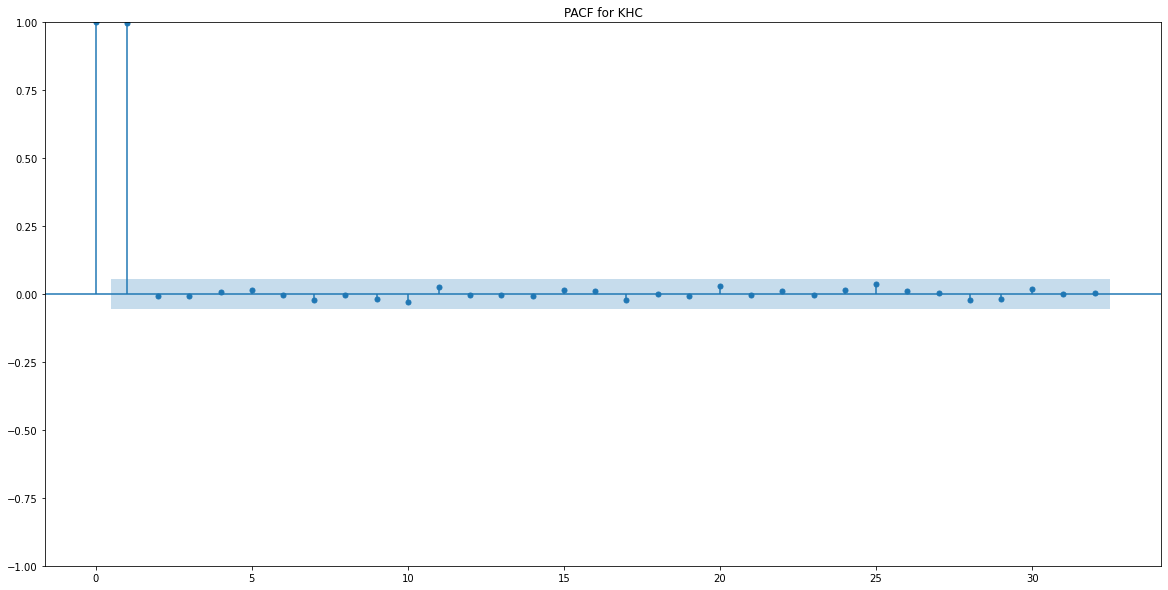

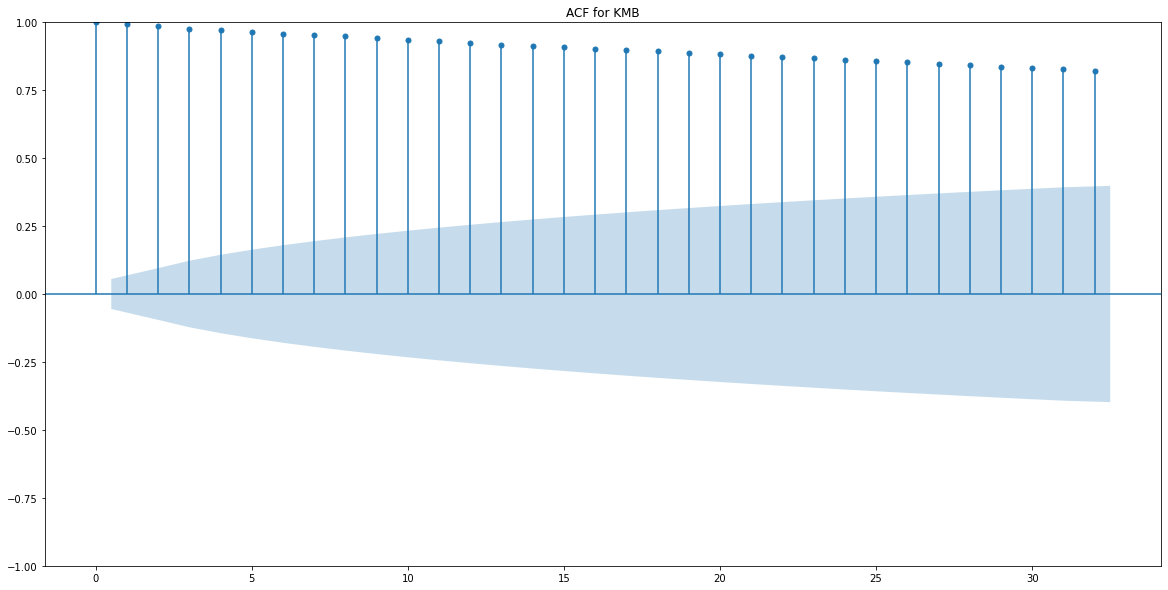

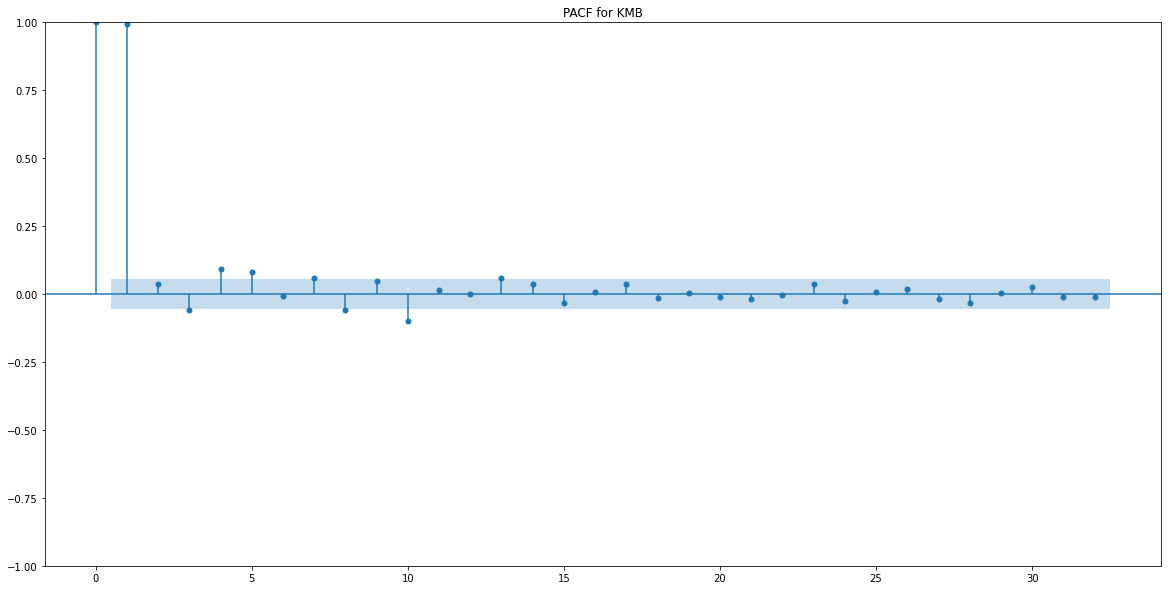

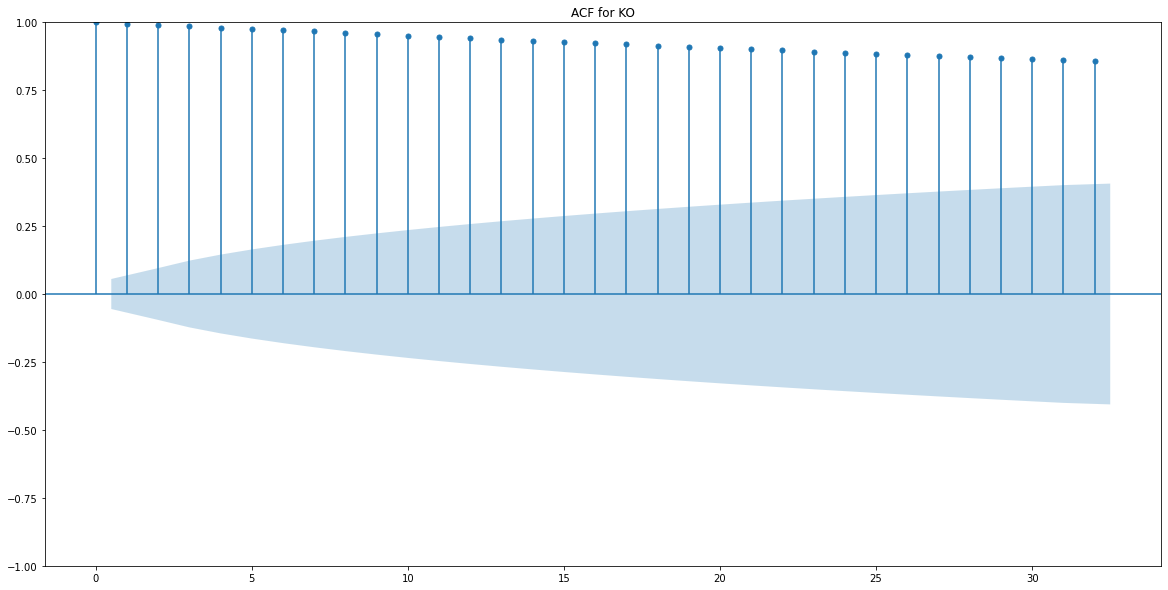

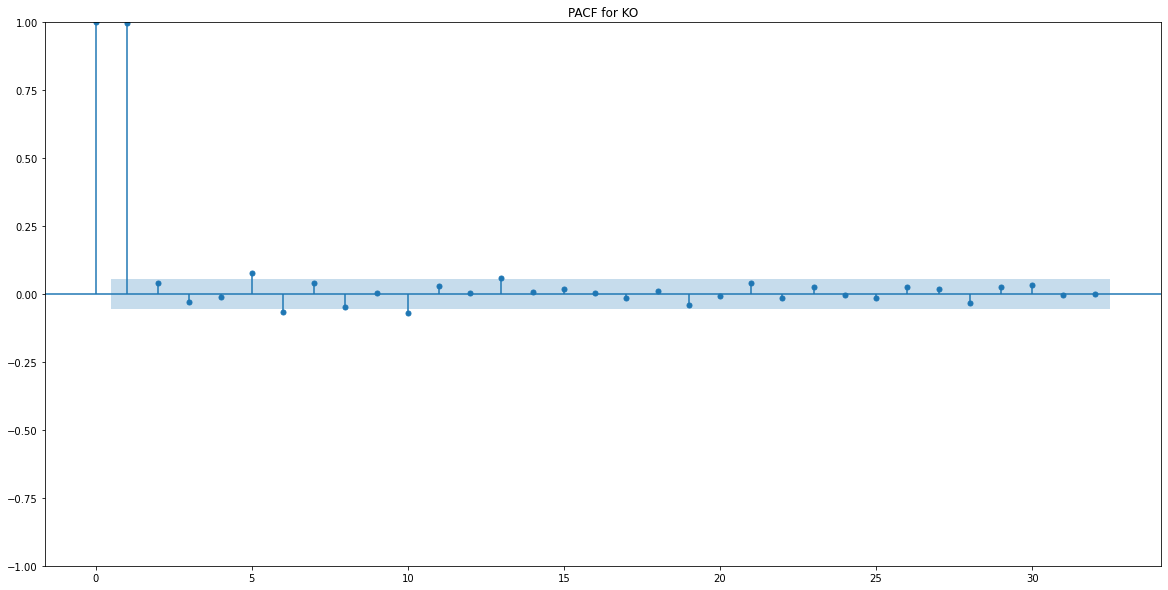

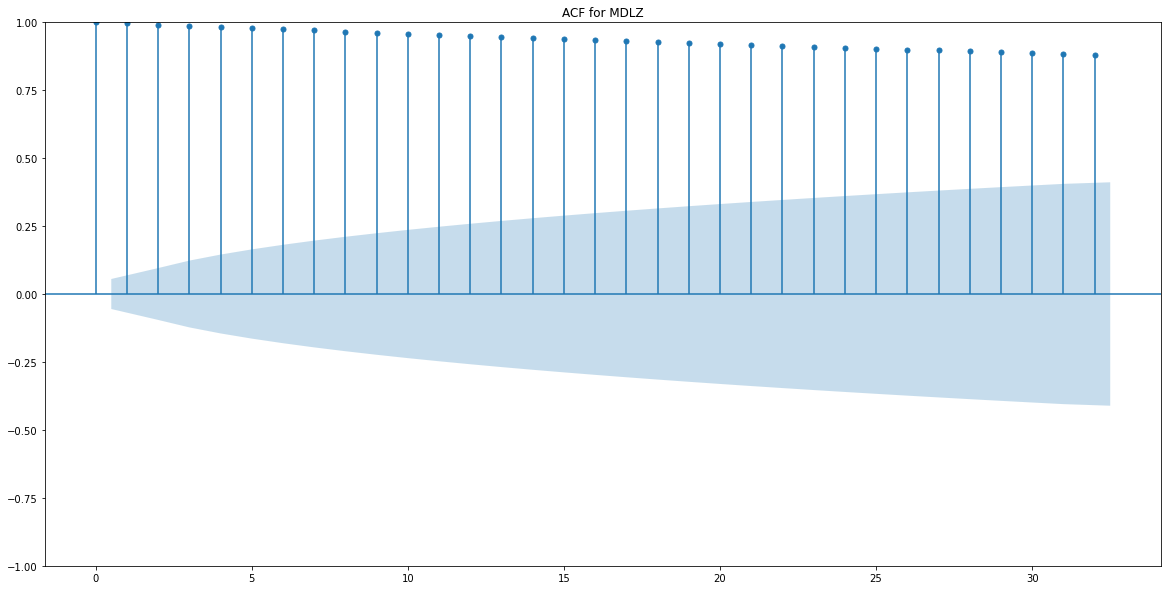

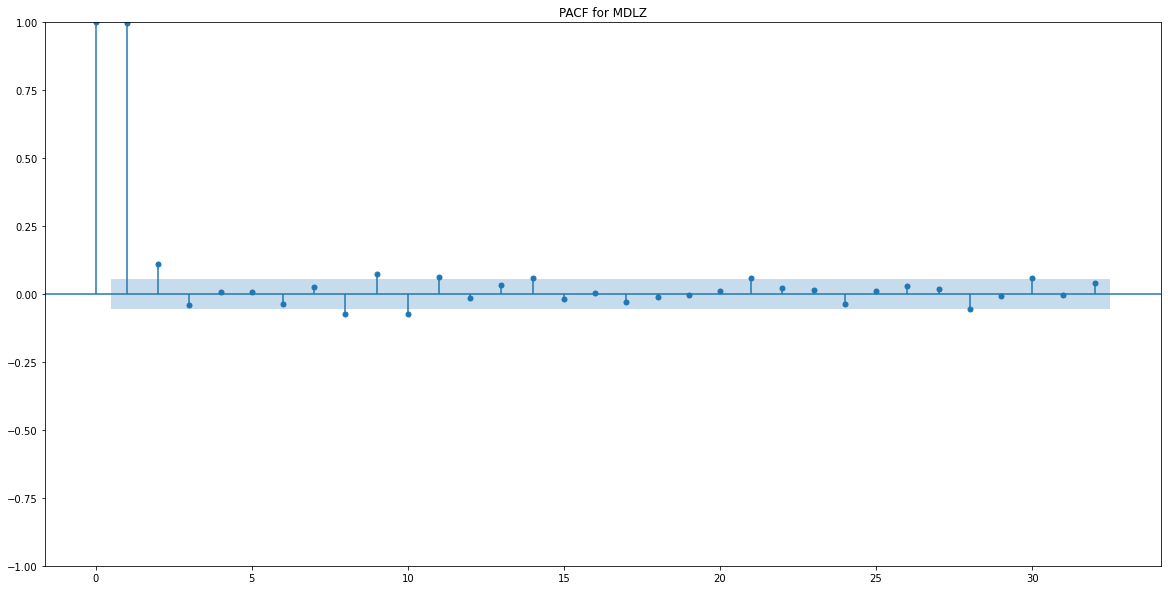

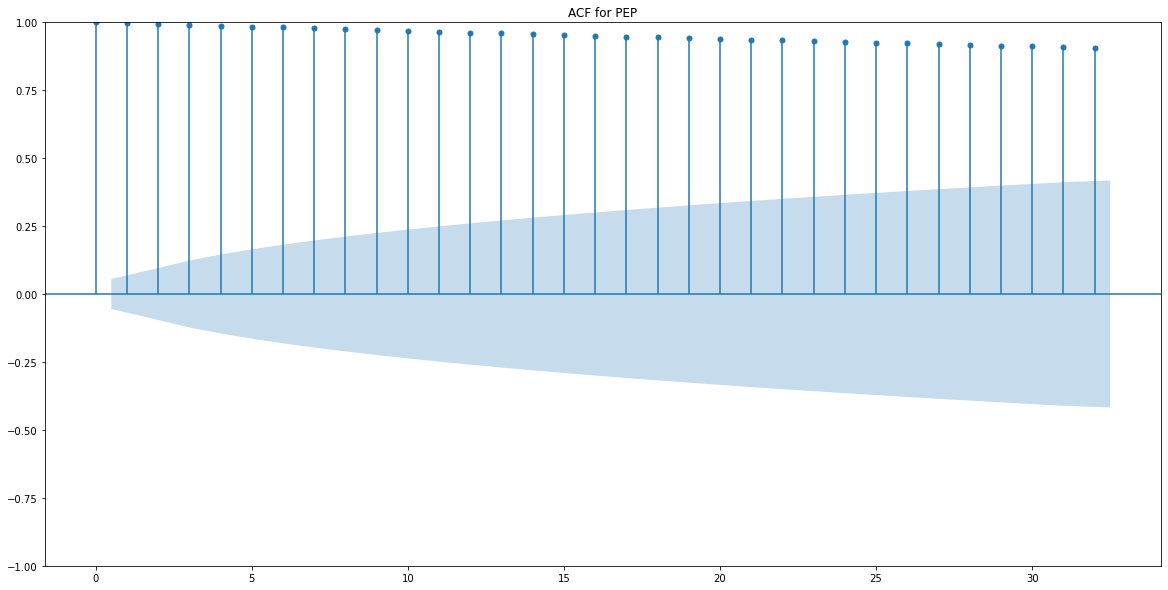

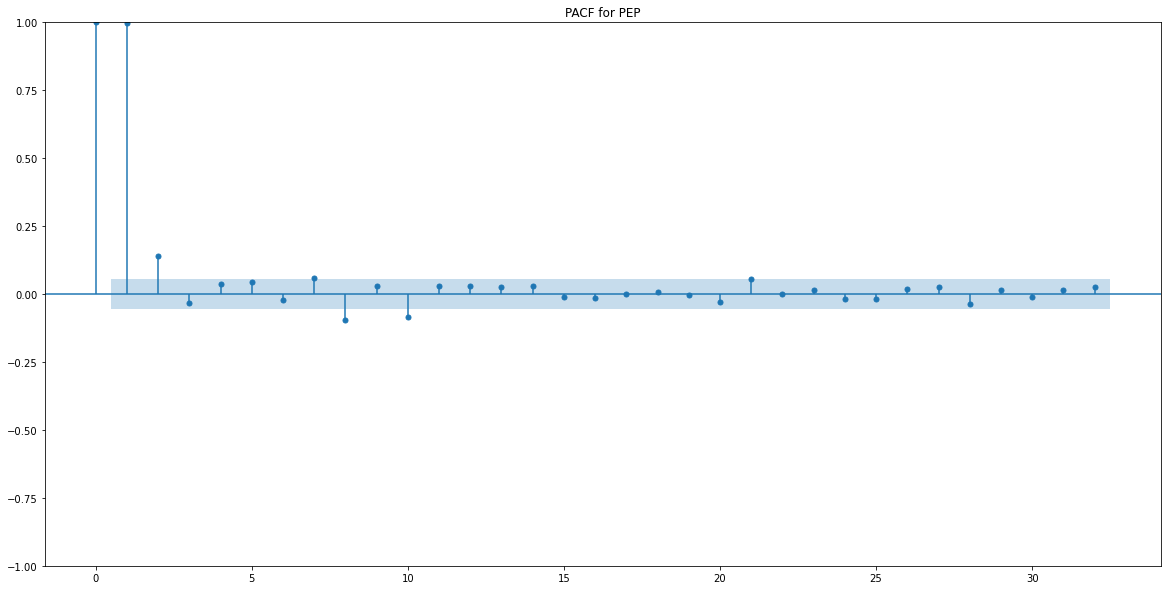

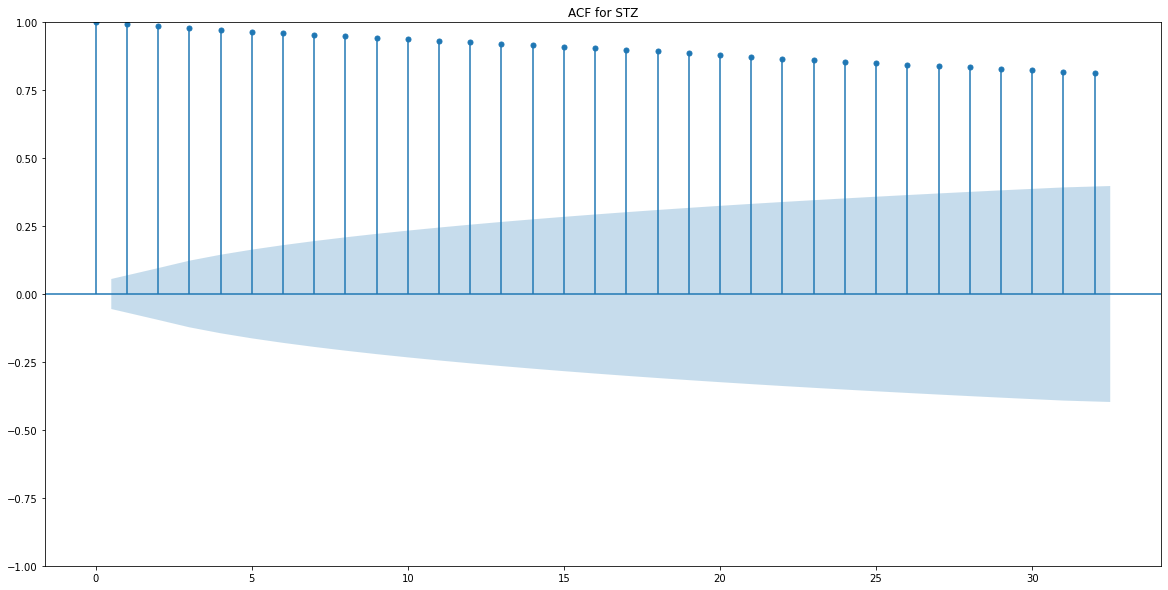

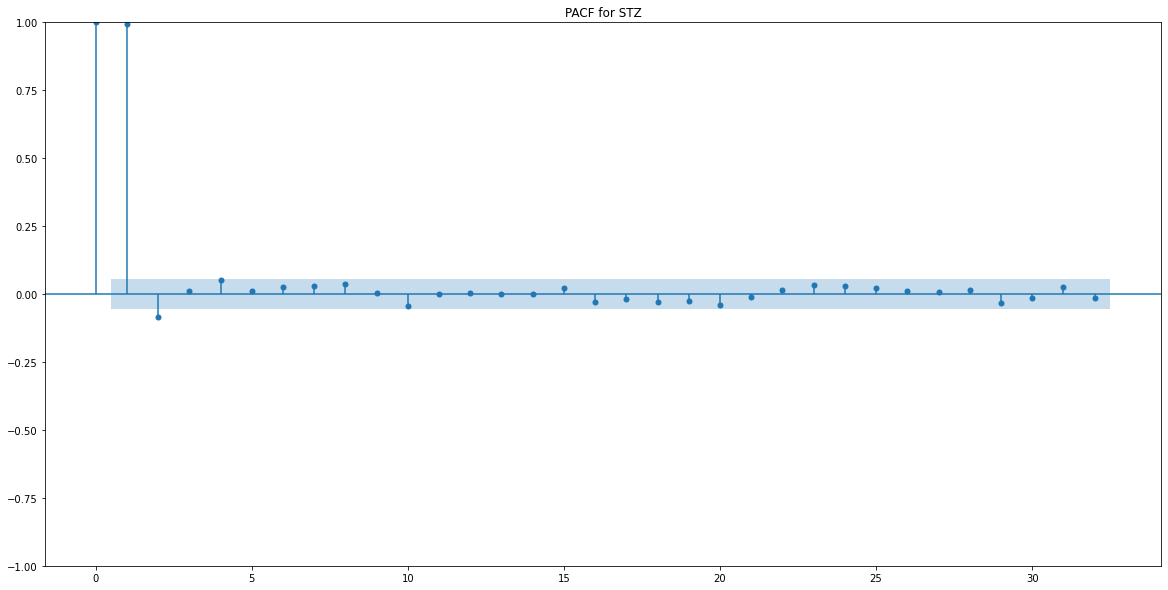

In [16]:
# ACF and PACF plots
for stock, data in stock_data.items():
    plot_acf(data)
    plt.title(f'ACF for {stock}')
    plt.show()
    
    plot_pacf(data)
    plt.title(f'PACF for {stock}')
    plt.show()


i;jlhjfvjkBy analyzing these plots:

ACF: If the ACF plot shows a gradual decline and cuts off after a certain lag (usually q), it suggests that the series can be well-modeled using the MA term.
PACF: If the PACF plot shows a significant spike at lag 'p' and then tails off, it suggests that the series can be well-modeled using the AR term.
The plots help to identify the orders 'p' and 'q' for ARIMA models. This information is crucial for building an effective ARIMA model and improving its forecast accuracy.

Both ACF and PACF plots provide valuable insights into the underlying structure of the time series data, which is essential for selecting appropriate models and forecasting future observations accurately.

## Time Series Forecasting using ARIMA

In [17]:
# ARIMA modeling with future predictions
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

def arima_model_and_forecast(stock_data):
    for stock, data in stock_data.items():
        train_data = data[:int(0.8 * len(data))]
        test_data = data[int(0.8 * len(data)):]
        
        # Use auto_arima to find the optimal hyperparameters
        model = auto_arima(train_data, seasonal=True, stepwise=True, suppress_warnings=True)
        order = model.get_params()['order']
        seasonal_order = model.get_params()['seasonal_order']
        
        # Fit the ARIMA model with the optimal hyperparameters
        fitted = ARIMA(train_data, order=order, seasonal_order=seasonal_order)
        fitted = fitted.fit()
        
        # Forecast for the next month (adjust the 'steps' as needed)
        forecast = fitted.forecast(steps=len(test_data))  
        mse = mean_squared_error(test_data, forecast)
        
        print(f'ARIMA modeling for {stock}:')
        print(f'Mean Squared Error: {mse}')
        

# Call the function to perform ARIMA modeling and future predictions
arima_model_and_forecast(stock_data)

ARIMA modeling for CL:
Mean Squared Error: 24.425152695619843
ARIMA modeling for CLX:
Mean Squared Error: 590.4724056671566
ARIMA modeling for EL:
Mean Squared Error: 5933.376408094145
ARIMA modeling for GIS:
Mean Squared Error: 66.32764830954501
ARIMA modeling for KHC:
Mean Squared Error: 12.731703140775132
ARIMA modeling for KMB:
Mean Squared Error: 108.90948574788878
ARIMA modeling for KO:
Mean Squared Error: 15.06767369789969
ARIMA modeling for MDLZ:
Mean Squared Error: 7.229309587515575
ARIMA modeling for PEP:
Mean Squared Error: 25.748097935089497
ARIMA modeling for STZ:
Mean Squared Error: 159.07419629750564


The Mean Squared Error (MSE) values obtained from the ARIMA models provide insights into the accuracy of the models in predicting the stock prices. Lower MSE values generally indicate better predictive performance, suggesting that the model's forecasts are closer to the actual values.

Here are the observations based on the MSE values:

1. **Lowest MSE**:
   - **KHC** and **MDLZ** exhibit the lowest MSE values among the stocks. This implies that the ARIMA model fits these stocks' data quite well. The forecasted values are closer to the actual values, indicating better performance.

2. **Moderate MSE**:
   - **KO**, **PEP**, **GIS**, and **CL** have moderate MSE values. The model's performance for these stocks is relatively average, showing forecasts reasonably close to the actual values but with a bit more variance.

3. **Higher MSE**:
   - **STZ**, **KMB**, **CLX**, and **EL** have higher MSE values. These stocks demonstrate poorer model performance compared to others. The higher MSE suggests a significant difference between the forecasted and actual values, indicating that the ARIMA model might not fit these stocks' data as well.

4. **Considerations**:
   - Lower MSE values don't necessarily mean the model is perfect, but they indicate better accuracy in forecasting. Higher MSE values might suggest the need for further investigation or exploring different models or data preprocessing techniques to improve the model's performance for these stocks.

5. **Additional Analysis**:
   - It's essential to consider other factors affecting the stock prices, as the stock market can be influenced by various external factors. Testing different hyperparameters and model configurations might enhance the model's forecasting accuracy.

The MSE values provide a comparative understanding of the ARIMA model's performance for different stocks. The results can guide further refinement or consideration of alternative models for stocks with higher MSE values to improve their forecast accuracy.

## Time Series Forecasting using AutoRegressive (AR) Model

In [18]:
from statsmodels.tsa.ar_model import AutoReg

# Function for AutoRegressive (AR) modeling
def ar_model_and_forecast(stock_data):
    for stock, data in stock_data.items():
        train_data = data[:int(0.8 * len(data))]
        test_data = data[int(0.8 * len(data)):]
        
        model = AutoReg(train_data, lags=1)  # You can adjust the number of lags
        fitted = model.fit()
        
        forecast = fitted.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)
        mse = mean_squared_error(test_data, forecast)
        
        print(f'AR modeling for {stock}:')
        print(f'Mean Squared Error: {mse}')

ar_model_and_forecast(stock_data)

AR modeling for CL:
Mean Squared Error: 9.129941458676216
AR modeling for CLX:
Mean Squared Error: 556.3475262188061
AR modeling for EL:
Mean Squared Error: 9771.196055976507
AR modeling for GIS:
Mean Squared Error: 101.82922609667159
AR modeling for KHC:
Mean Squared Error: 22.19132855744605
AR modeling for KMB:
Mean Squared Error: 53.80242913725104
AR modeling for KO:
Mean Squared Error: 48.57581416542658
AR modeling for MDLZ:
Mean Squared Error: 6.551367350171819
AR modeling for PEP:
Mean Squared Error: 25.082525173400782
AR modeling for STZ:
Mean Squared Error: 401.24929518243454


Based on the Mean Squared Error (MSE) values obtained from our AR and ARIMA models, we can make the following interpretations:

Lower MSE Values: Stocks with lower MSE values indicate better model performance, meaning that the model's forecasts are closer to the actual values, showing good accuracy in predictions.

Comparing AR and ARIMA Models:

For most of the stocks (CL, KHC, KO, MDLZ, and PEP), the AR model has lower MSE values compared to the ARIMA model. This suggests that the AR model may be a better choice for forecasting these stocks.

For stocks like CLX, EL, GIS, KMB, and STZ, both the AR and ARIMA models show relatively higher MSE values, indicating that these stocks might be challenging to forecast accurately using either of these models.

Individual Stock Considerations: It's important to consider the characteristics of each stock and its historical price data. Some stocks may exhibit patterns that are better captured by certain models, while others may have more complex and unpredictable behaviors.

## Time Series Forecasting using Moving Average (MA) Model

In [19]:
from statsmodels.tsa.arima.model import ARIMA

def ma_model_and_forecast(stock_data):
    for stock, data in stock_data.items():
        train_data = data[:int(0.8 * len(data))]
        test_data = data[int(0.8 * len(data)):]
        
        # Use auto_arima to find the optimal hyperparameters
        model = auto_arima(train_data, seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore")
        order = model.get_params()['order']
        
        # Fit the MA model with the optimal hyperparameters
        fitted = ARIMA(train_data, order=(0, 0, order[2]))  # Set the order parameter
        fitted = fitted.fit()
        
        # Forecast for the next month (adjust the 'steps' as needed)
        forecast = fitted.forecast(steps=len(test_data))
        mse = mean_squared_error(test_data, forecast)
        
        print(f'MA modeling for {stock}:')
        #print(f'Optimal MA Order: {order[2]}')
        print(f'Mean Squared Error: {mse}')


In [20]:
ma_model_and_forecast(stock_data)

MA modeling for CL:
Mean Squared Error: 80.3128719038052
MA modeling for CLX:
Mean Squared Error: 229.04642544944156
MA modeling for EL:
Mean Squared Error: 3578.3098329670893
MA modeling for GIS:
Mean Squared Error: 461.5985443195549
MA modeling for KHC:
Mean Squared Error: 10.569467778469676
MA modeling for KMB:
Mean Squared Error: 145.7094594673844
MA modeling for KO:
Mean Squared Error: 200.5732937495076
MA modeling for MDLZ:
Mean Squared Error: 167.40547276897553
MA modeling for PEP:
Mean Squared Error: 1962.1108697287941
MA modeling for STZ:
Mean Squared Error: 1761.1585497392555


AutoRegressive (AR) Model:

* For most of the stocks, the AR model yields relatively low Mean Squared Error (MSE) values, which suggests that it performs well in capturing the autoregressive component of these stock prices.
* CL, KHC, and MDLZ exhibit particularly low MSE values, indicating better performance and good accuracy in predicting their future values.
* While AR performs well for some stocks, it may not be suitable for others (e.g., EL, CLX) as indicated by higher MSE values.

Moving Average (MA) Model:

* The MA model produces higher MSE values for most of the stocks compared to the AR model, suggesting that it may not be the most suitable choice for these stocks.
* KHC and CLX have relatively low MSE values for the MA model, indicating better performance and suitability for this model.
* For some stocks (e.g., EL, GIS, PEP), the MA model exhibits significantly higher MSE values, indicating poor performance in capturing the moving average patterns.

AutoRegressive Integrated Moving Average (ARIMA) Model:

* The ARIMA model typically yields performance that falls between AR and MA models, as expected because it combines both autoregressive and moving average components.
* For KHC and MDLZ, the ARIMA model has the lowest MSE values among the three models, suggesting that it fits their data quite well and provides better accuracy in forecasting.
* The ARIMA model may not be the best choice for EL, CLX, and EL, as indicated by relatively high MSE values.

In summary, based on the model performance observed:

* Consider using AR for stocks with low MSE values for AR models, like CL, KHC, and MDLZ.
* Use the MA model for stocks with low MSE values for MA models, such as KHC and CLX.
* The ARIMA model can be a reasonable choice for several stocks and is worth exploring when you want a balance between autoregressive and moving average components.

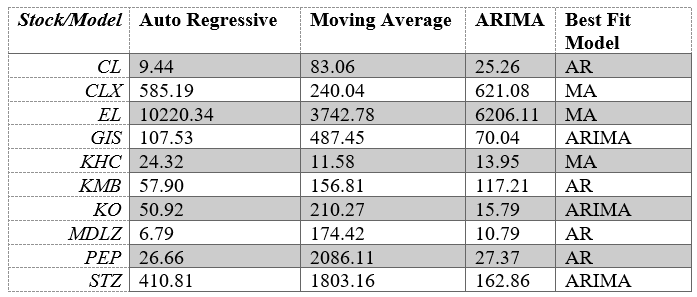

## Forecasting Future Stock Values

In [21]:
# Define the best-fit models for each stock based on our analysis
best_fit_models = {
    'CL': 'AR',
    'CLX': 'MA',
    'EL': 'MA',
    'GIS': 'ARIMA',
    'KHC': 'MA',
    'KMB': 'AR',
    'KO': 'ARIMA',
    'MDLZ': 'AR',
    'PEP': 'AR',
    'STZ': 'ARIMA',
}

In [22]:
# Function to forecast future stock values using the chosen best-fit model
def forecast_future_stock_values(stock_data, best_fit_models, forecast_steps=15):
    forecasts = {}
    for stock, data in stock_data.items():
        best_fit_model = best_fit_models[stock]
        train_data = data[:int(0.8 * len(data))]
        
        # Check which best-fit model to use and forecast accordingly
        if best_fit_model == 'AR':
            model = AutoReg(train_data,lags=1)
            fitted = model.fit()
            forecast = fitted.predict(start=len(train_data), end=len(train_data) + forecast_steps - 1, dynamic=False)
        elif best_fit_model == 'MA':
            model = ARIMA(train_data, order=(0, 0, 1))
            fitted = model.fit()
            forecast = fitted.forecast(steps=forecast_steps)
        elif best_fit_model == 'ARIMA':
            model = auto_arima(train_data, seasonal=True, stepwise=True, suppress_warnings=True)
            order = model.get_params()['order']
            seasonal_order = model.get_params()['seasonal_order']
            fitted = ARIMA(train_data, order=order, seasonal_order=seasonal_order)
            fitted = fitted.fit()
            forecast = fitted.forecast(steps=forecast_steps)

        forecasts[stock] = forecast

    return forecasts

# Call the function to forecast future stock values
forecasted_values = forecast_future_stock_values(stock_data, best_fit_models, forecast_steps=15)

# Display the forecasted values
for stock, forecast in forecasted_values.items():
    print(f'Forecasted values for {stock}:')
    print(forecast)

Forecasted values for CL:
1007    77.583548
1008    77.533024
1009    77.482760
1010    77.432754
1011    77.383006
1012    77.333513
1013    77.284275
1014    77.235290
1015    77.186556
1016    77.138073
1017    77.089840
1018    77.041854
1019    76.994116
1020    76.946622
1021    76.899373
dtype: float64
Forecasted values for CLX:
1007    146.901215
1008    146.524328
1009    146.524328
1010    146.524328
1011    146.524328
1012    146.524328
1013    146.524328
1014    146.524328
1015    146.524328
1016    146.524328
1017    146.524328
1018    146.524328
1019    146.524328
1020    146.524328
1021    146.524328
Name: predicted_mean, dtype: float64
Forecasted values for EL:
1007    255.665602
1008    196.322270
1009    196.322270
1010    196.322270
1011    196.322270
1012    196.322270
1013    196.322270
1014    196.322270
1015    196.322270
1016    196.322270
1017    196.322270
1018    196.322270
1019    196.322270
1020    196.322270
1021    196.322270
Name: predicted_mean, dtype: 

## Portfolio-Level Forecast

In [23]:
def combine_portfolio_forecasts(stock_data, best_fit_models, forecast_steps, portfolio_allocation):
    portfolio_forecasts = None
    
    for stock, model in best_fit_models.items():
        if model == 'AR':
            fitted = AutoReg(stock_data[stock], lags=1).fit()
            forecast = fitted.predict(start=len(stock_data[stock]), end=len(stock_data[stock]) + forecast_steps - 1, dynamic=False)
        elif model == 'MA':
            model = ARIMA(stock_data[stock], order=(0, 0, 1))
            fitted = model.fit()
            forecast = fitted.forecast(steps=forecast_steps)
        else:  # ARIMA
            model = auto_arima(stock_data[stock], seasonal=True, stepwise=True, suppress_warnings=True)
            order = model.get_params()['order']
            seasonal_order = model.get_params()['seasonal_order']
            fitted = ARIMA(stock_data[stock], order=order, seasonal_order=seasonal_order)
            fitted = fitted.fit()
            forecast = fitted.forecast(steps=forecast_steps)
        
        weighted_forecast = forecast * portfolio_allocation[stock]
        
        if portfolio_forecasts is None:
            portfolio_forecasts = weighted_forecast
        else:
            portfolio_forecasts += weighted_forecast
    
    return portfolio_forecasts

portfolio_allocation = {
    'CL': 0.25,
    'CLX': 0.1,
    'EL': 0.08,
    'GIS': 0.05,
    'KHC': 0.3,
    'KMB': 0.09,
    'KO': 0.06,
    'MDLZ': 0.03,
    'PEP': 0.03,
    'STZ': 0.01
}

portfolio_forecasts = combine_portfolio_forecasts(stock_data, best_fit_models, 15, portfolio_allocation)

print("Portfolio-Level Forecast:")
print(portfolio_forecasts)

Portfolio-Level Forecast:
1259    86.787188
1260    87.347901
1261    87.329839
1262    87.312405
1263    87.294625
1264    87.277197
1265    87.259685
1266    87.242323
1267    87.225027
1268    87.207787
1269    87.190665
1270    87.173581
1271    87.156615
1272    87.139701
1273    87.122888
dtype: float64


## Portfolio Performance Metrics

In [24]:
import pandas as pd

def calculate_portfolio_metrics(portfolio_forecast, portfolio_allocation):
    # Calculate the daily return for each stock
    stock_returns = {}
    for stock, weight in portfolio_allocation.items():
        stock_returns[stock] = portfolio_forecast * weight

    # Combine individual stock returns to get the portfolio's daily return
    portfolio_returns = sum(stock_returns.values())

    # Calculate cumulative return
    cumulative_return = (portfolio_returns + 1).cumprod()

    # Calculate average daily return
    average_daily_return = portfolio_returns.mean()

    # Calculate volatility (standard deviation of daily returns)
    volatility = portfolio_returns.std()

    # Assume a risk-free rate, e.g., 0.03 (3% annual return) as an example
    risk_free_rate = 0.03 / 252  # Assuming 252 trading days in a year

    # Calculate Sharpe ratio
    sharpe_ratio = (average_daily_return - risk_free_rate) / volatility

    return {
        "portfolio_returns": portfolio_returns,
        "cumulative_return": cumulative_return,
        "average_daily_return": average_daily_return,
        "volatility": volatility,
        "sharpe_ratio": sharpe_ratio,
    }

# Calculate portfolio performance metrics for each time step
portfolio_df = pd.DataFrame(portfolio_forecasts)
portfolio_metrics = {"Day 0": calculate_portfolio_metrics(portfolio_df.iloc[0], portfolio_allocation)}
cumulative_return = 1.0  # Initialize cumulative return

for step in range(len(portfolio_df)):
    if step > 0:
        metrics = calculate_portfolio_metrics(portfolio_df.iloc[step], portfolio_allocation)
        portfolio_metrics[f"Day {step + 1}"] = metrics
        cumulative_return *= (1 + metrics["average_daily_return"])


# Display portfolio performance metrics and decisions for each time step
for step, metrics in portfolio_metrics.items():
    print(f"{step} - Portfolio Performance Metrics:")
    print(f"Portfolio Returns: {metrics['portfolio_returns'].mean():.2f}")
    print(f"Cumulative Return: {metrics['cumulative_return'].iloc[-1]:.2f}")
    print(f"Average Daily Return: {metrics['average_daily_return']:.2f}")
    print(f"Volatility: {metrics['volatility']:.2f}")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")

    # Example decision logic:
    if metrics["sharpe_ratio"] < 0.05 and metrics["volatility"] > 0.2:
        print("Consider rearranging the portfolio to reduce risk and improve returns.")
    else:
        print("The portfolio is performing well based on the current allocation.")
    print()


Day 0 - Portfolio Performance Metrics:
Portfolio Returns: 86.79
Cumulative Return: 87.79
Average Daily Return: 86.79
Volatility: nan
Sharpe Ratio: nan
The portfolio is performing well based on the current allocation.

Day 2 - Portfolio Performance Metrics:
Portfolio Returns: 87.35
Cumulative Return: 88.35
Average Daily Return: 87.35
Volatility: nan
Sharpe Ratio: nan
The portfolio is performing well based on the current allocation.

Day 3 - Portfolio Performance Metrics:
Portfolio Returns: 87.33
Cumulative Return: 88.33
Average Daily Return: 87.33
Volatility: nan
Sharpe Ratio: nan
The portfolio is performing well based on the current allocation.

Day 4 - Portfolio Performance Metrics:
Portfolio Returns: 87.31
Cumulative Return: 88.31
Average Daily Return: 87.31
Volatility: nan
Sharpe Ratio: nan
The portfolio is performing well based on the current allocation.

Day 5 - Portfolio Performance Metrics:
Portfolio Returns: 87.29
Cumulative Return: 88.29
Average Daily Return: 87.29
Volatility: